
<div style="background-image: url(https://www.brgm.fr/sites/default/files/styles/page_top_banner/public/images_banner/2022-07/banniere-0334.jpg.webp); background-position: 0% 5%; padding: 10px; display: flex;">
    <div style="display: flex; align-items: left;">
        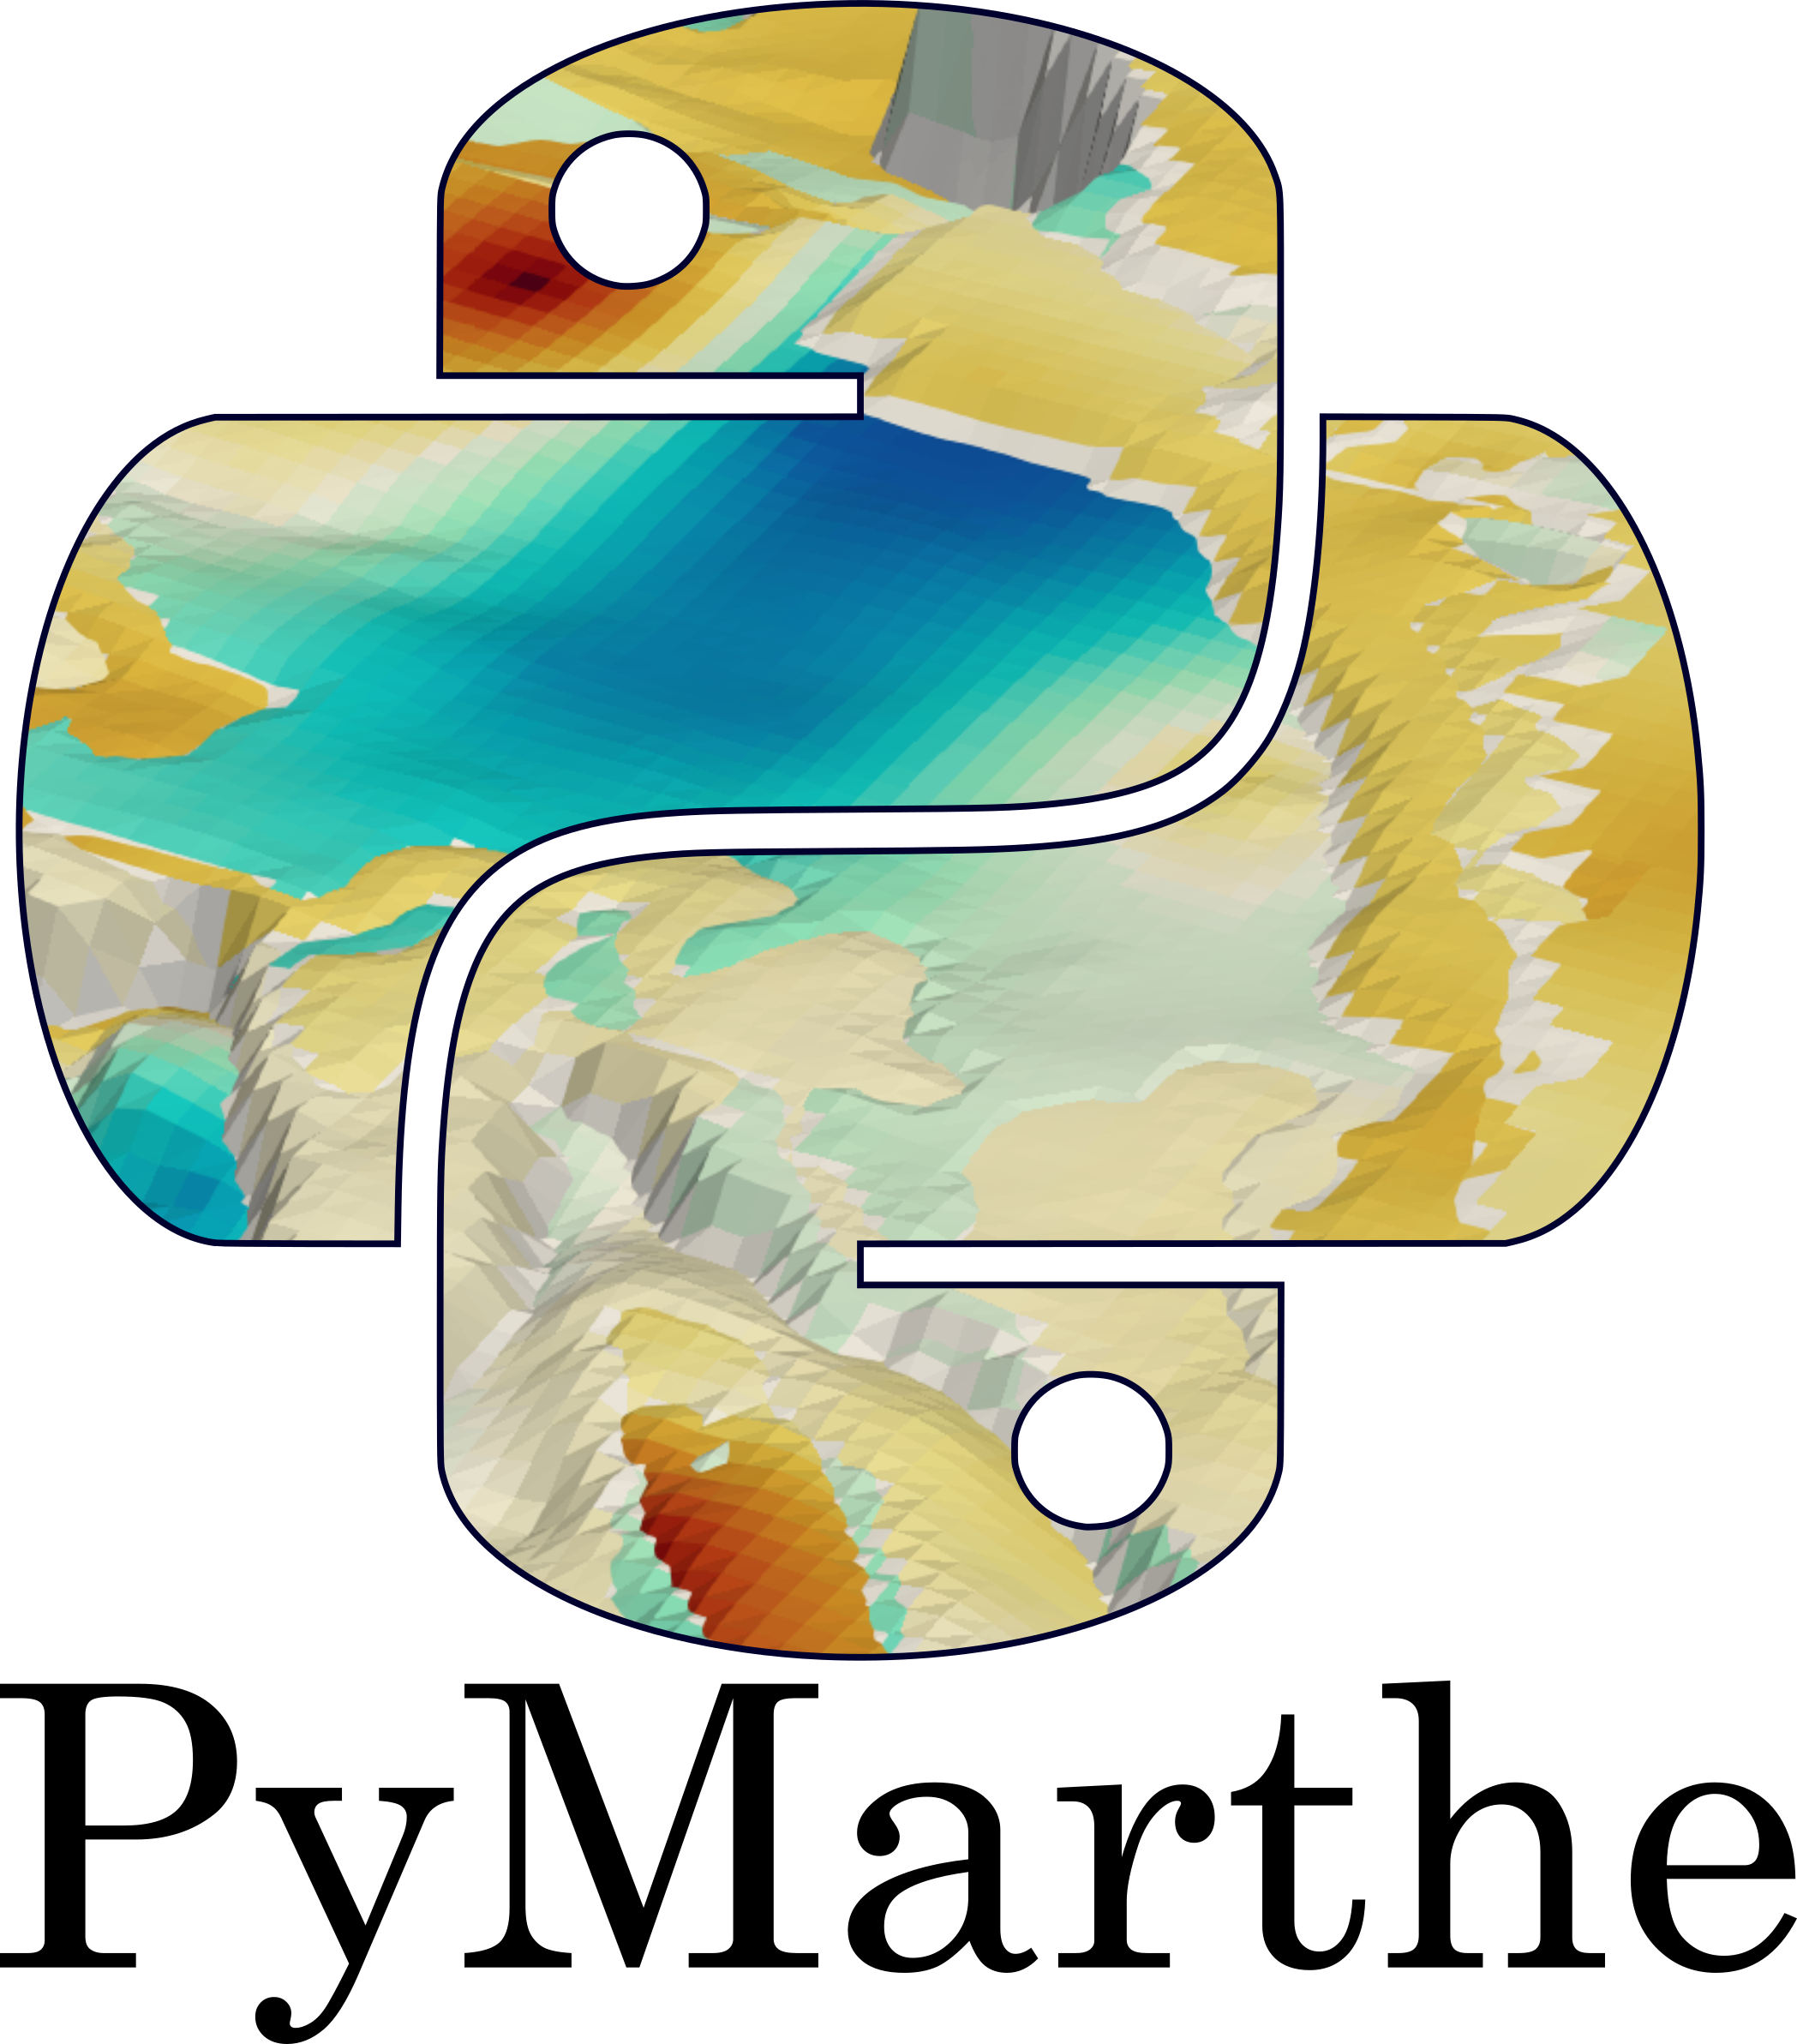
        <div style="text-align: center; align-items: center; padding-left: 40px; padding-top:40px;">
            <p style="color: black; font-size: 60px;"><b>Advance Usage Guide 🤵</b></p>
            <p style="color: #2b2b2b; font-size: 22px; padding-top:10px"><i>Get ready for model parameter optimisation</i></p>
            <p style="color: white; font-size: 18px; text-align: right; padding-top: 50px;">
                <i><b>Novice</b></i>❌ - <i><b>Intermediate</b></i>✅ - <i><b>Expert</b></i>✅
            </p>
        </div>
    </div>
</div>

<br>

`PyMarthe` is a python wrapper acting as a _"coupling interface"_ between [**MARTHE (v7.5)**](https://www.brgm.fr/fr/logiciel/marthe-logiciel-modelisation-ecoulements-souterrains) hydrogeological numerical models design by the **BRGM** and optimization algorithms provided by the [**PEST++**](https://github.com/usgs/pestpp) facilities.

<p align="center">
  <img 
  src="../assets/PyMarthe_v1.0_general.png"
  alt="PyMarthe v1.0" 
  width="650"
  height="415"
  >
</p>

📢 The `PyMarthe` library provides to the user the ability to manage **observations data**, **parametrize _grid-like_ / _list-like_ model properties** and convert them to `PEST` formatted files in order to carry out **calibration**, **optimisation** and **sensitivity** & **uncertainty** analysis processes on a **Marthe** model.<br>

In this initiation, we will manipulate exclusivly the **MONA** _(**MO**dèle **N**ord **A**quatain)_ model (_`examples/monav3/`_).<br>

To begin with, let's set the notebook environement.

In [1]:
# ---- Import basic modules
import os, sys
from glob import glob
import shutil
import pandas as pd
import numpy as np

# -- Import visualisation modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# -- Set relative pymarthe path
sys.path.insert(0, '..')

# -- Import pymarthe modules
from pymarthe import MartheModel
from pymarthe.utils import marthe_utils, shp_utils, pest_utils
from pymarthe.utils.pp_utils import PilotPoints
from pymarthe.mfield import MartheField
from pymarthe.moptim import MartheOptim

# ---- Set model's relative paths
mona_ws = os.path.join( 'monav3', 'mona.rma')
mona_si = os.path.join('monav3', 'mona_si')

# -- Set MARTHE model executable name
EXE_NAME = 'Marth_R8' # Make sure to put yours!

# -- Create a brand new 'pest' folder to work with
wdir = os.path.join('monav3', 'pest')
shutil.rmtree(wdir, ignore_errors=True)

________________________________________________      
  ____        __  __            _   _          
 |  _ \ _   _|  \/  | __ _ _ __| |_| |__   ___ 
 | |_) | | | | |\/| |/ _` | '__| __| '_ \ / _ \
 |  __/| |_| | |  | | (_| | |  | |_| | | |  __/
 |_|    \__, |_|  |_|\__,_|_|   \__|_| |_|\___|
        |___/                                                                             
________________________________________________


# 🎇 **`MartheOptim` instance** 🎇

The `MartheOptim` instance was implemented to manage both **observation** and **parameter** data of a parent `MartheModel` object in order to link **Marthe** model runs with some **PEST** utilities to **estimate**, **calibrate** and **optimise** models. To sum up, it's a python `wrapper` between **Marthe** and **PEST**.<br>

`MartheOptim` is based around **hypothetical _"boxes"_** represented by basic python dictionaries:<br>
&emsp;&emsp;➼ `.obs`: observation storage<br>
&emsp;&emsp;➼ `.param`: parameter storage<br>

The entire goal of the parametrization process consists on filling those **_"boxes"_** with model data (_properties_, _observation records_) using internal methods / tools provided by `MartheOptim` object.<br>

<p align="center">
  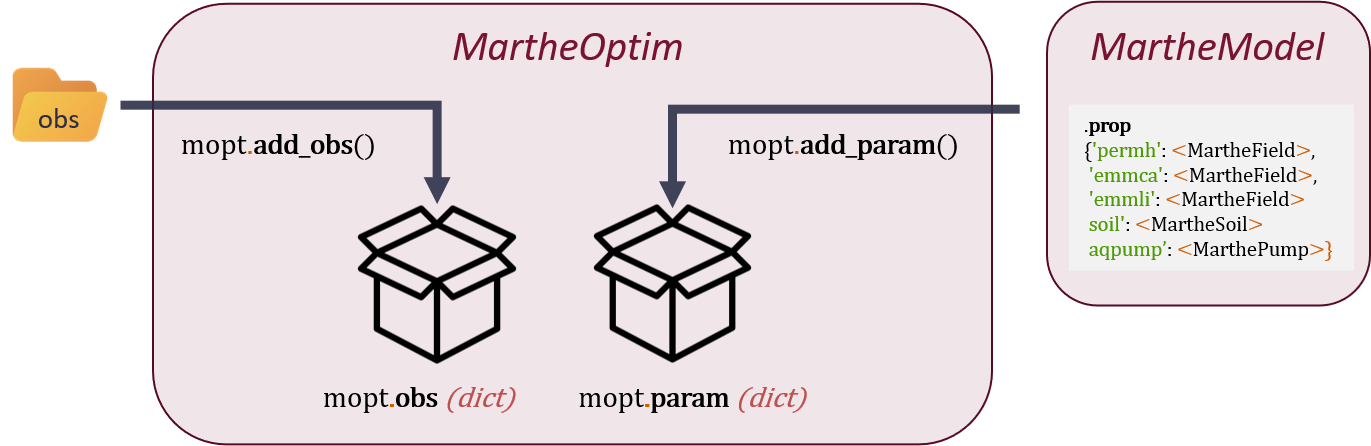
</p>

Let's start slowly and load the `MartheModel` object then organize the **pest directories**.

In [2]:
# -- Load MartheModel object
mm = MartheModel(mona_ws, spatial_index=mona_si, modelgrid=True)

# -- Setup PEST directories
pest_dirs = {}
for folder in ['par', 'tpl', 'ins', 'sim']:
    # -- Build path
    path = os.path.join(mm.mldir, 'pest' , folder)
    # -- Build clean pest folder
    os.makedirs(path, exist_ok=True)
    # -- Store pest directories
    pest_dirs[f'{folder}_dir'] = path

Next, let's create a `MartheOptim` object for our experiment.

In [55]:
# -- Build MartheOptim object
mopt = MartheOptim(mm, name='opti_mona', **pest_dirs)

# -- Print basic infos
print('\t', mopt, '\n', '-'*30)
print('Optimization experiment name:', mopt.name)
print('PEST file directories:\n\t-', '\n\t- '.join([mopt.par_dir, mopt.tpl_dir, mopt.ins_dir, mopt.sim_dir]))
print('Time window:', mopt.tw_min, '==>', mopt.tw_max)
print('Observation(s) storage:', mopt.obs, '(empty)')
print('Parameter(s) storage:', mopt.param, '(empty)')

	 MartheOptim 
 ------------------------------
Optimization experiment name: opti_mona
PEST file directories:
	- monav3\pest\par
	- monav3\pest\tpl
	- monav3\pest\ins
	- monav3\pest\sim
Time window: 1972-12-31 00:00:00 ==> 2011-12-31 00:00:00
Observation(s) storage: {} (empty)
Parameter(s) storage: {} (empty)


<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> the user can easily perform <b>various parametrization experiments</b> by creating a new <code>MartheOptim</code> instance giving it a specific <code>name</code> (<i>ex:</i> <code>name='permh_calibration'</code>)
    </span>
</div>

# 🎇 **Obervations management** 🎇

## 👉 Add basic observations

Observation data are absolutly crucial for **historic matching** optimisation. To add observation data in `MartheOptim`, consider using the `.add_obs()` method. The addition of a set of observation data may come from a:

- **External file** (ex: _.txt_ or _.csv_ file)
- **`DataFrame`** object

When adding a set of observation data, the user must remember to specify a _"type"_ of observation (`datatype`) such as _`'head'`_, _`'flow'`_, _`'soil'`_, ...<br>

A custom name can be given to a specific set of observation (_ex:_ `locname='07065X0002'`).

<div class="alert alert-danger" role="alert">
    <span style="color: red; font-size: 16px; font-weight: bold;">⛔ CAREFUL: </span>
    <span style="color: darkred;"> the provided observation data <b>must contain</b> a column named <code>value</code> and an index of type <b>DatetimeIndex</b>. For external files, make sure that columns are separated by <b>any white space</b> (<i>tabulation is prefered</i>).
    </span>
</div>

In [4]:
# -- Implement basic observation data (external)
ext_file = os.path.join(mm.mldir, 'obs', '07065X0002.dat')
mopt.add_obs(data=ext_file, datatype='head') # same as locname='07065X0002'

# -- Check observation storage
print('Observation storage:')
mopt.obs

Observation storage:


{'07065X0002': <pymarthe.mobs.MartheObs at 0x199f10477c0>}

<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> for external data files, setting <code>locname=None</code> will automatically take the external file name as actual <code>locname</code>.
    </span>
</div>

`MartheOptim` provides an additional _easy-to-use_ check about observation `locname`. In fact, in order to perform optimisation by **historic matching**, it is highly recommended, not to say essential, to **check** that the observation we want to add is both **present** and **unique** in the _.histo_ file so that the **Marthe** model will therefore write the output data of this located point in the _historiq.prn_ file.<br>

To check unicity and existence of a specific `locname`, consider using the internal `.check_loc()` method. When an observation set i being added, the `locname` is checked by default. To disable it, use `check_loc=False`.

In [5]:
# -- Check invalid locname
# mopt.check_loc('P42')

In [6]:
# -- Check valid locname
mopt.check_loc('07065X0002')

<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> the user can view all available <code>locname</code> if required using <code>.available_locnames</code>.
    </span>
</div>

In [7]:
# -- Add previous observation without checking locname
mopt.add_obs(data=ext_file, datatype='head', check_loc=False)

# -- Check observation storage
print('Observation storage:')
mopt.obs

Observation storage:


C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\moptim.py:355: Warning: WARNING : locnme `07065X0002` already added. It will be overwrited.


{'07065X0002': <pymarthe.mobs.MartheObs at 0x199f10477c0>}

<div class="alert alert-warning" role="alert">
    <span style="color: darkorange; font-size: 16px; font-weight: bold;">⚠ Warning: </span>
    <span style="color: darkorange;"> if the user provides observation records <b>beyond the model time window</b>, a <b>warnings will be raised</b> and only observations that fall in the actual model time window will be considered.</span>
</div>

For each added set of observation, a specific `MartheObs` instance is created. To have a look on all added observations, consider using the `.get_obs_df()` to convert `MartheObs` instances to a large comprehensive `DataFrame` object.

In [8]:
# -- Print MartheObs infos
mobs = mopt.obs['07065X0002']
print('\t', mobs, '\n', '-'*30)
print('Observation source file:', mobs.obsfile)
print('Observation iloc:', mobs.iloc) # i-th observation set added
print('Observation datatype:', mobs.datatype)
print('Observation locname:', mobs.locnme)
print('Observation group name:', mobs.obgnme)
print('Observations values:\n', mobs.value)

	 MartheObs 
 ------------------------------
Observation source file: monav3\obs\07065X0002.dat
Observation iloc: 0
Observation datatype: head
Observation locname: 07065X0002
Observation group name: 07065X0002
Observations values:
 [-9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03
 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03
  1.140e+00 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03
 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03
  1.290e+01 -9.999e+03  1.335e+01  1.440e+01  1.732e+01  1.620e+01
  1.640e+01 -9.999e+03  1.680e+01  1.810e+01  1.611e+01  1.983e+01
  1.646e+01  1.613e+01  1.629e+01  1.621e+01]


In [9]:
# -- Get all observation data as DataFrame
obs_df = mopt.get_obs_df()

# -- Print added observation data
obs_df.head()

,obsnme,date,obsval,datatype,locnme,obsfile,weight,obgnme,trans
loc000n00,loc000n00,1972-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
loc000n01,loc000n01,1973-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
loc000n02,loc000n02,1974-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
loc000n03,loc000n03,1975-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
loc000n04,loc000n04,1976-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none


Even if the user can specify **custom names** for each values (`obsnme`) of an observation set, it is **strongly recommended** to let `MartheOptim` build **generic observations names** easily readable by **PEST** algorithms.<br>
These observation names are build following the following format:

<p style="text-weight: bold; text-align: center; font-size: 19px; color: #6B8E23; background-color: #F5F5F5; padding: 5px">
    <b>loc&nbsp;&nbsp;➕&nbsp;&nbsp;&#60;<i>i-th</i> observation location &#62;&nbsp;&nbsp;➕&nbsp;&nbsp;n&nbsp;&nbsp;➕&nbsp;&nbsp;&#60;<i>i-th</i> observation id&#62;
    </b>
</p>
<br> 

In [10]:
# -- Add custom observation names
mopt.add_obs(data=ext_file, datatype='head',
             obsnmes=['obs' + str(i).zfill(2) for i in range(mm.nstep)])

# -- Print added observation data
mopt.get_obs_df().head()

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\moptim.py:355: Warning: WARNING : locnme `07065X0002` already added. It will be overwrited.


,obsnme,date,obsval,datatype,locnme,obsfile,weight,obgnme,trans
obs00,obs00,1972-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
obs01,obs01,1973-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
obs02,obs02,1974-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
obs03,obs03,1975-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
obs04,obs04,1976-12-31 00:00:00,-9999.0,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none


The observation storage `.obs` is consider as a dynamic _**"box"**_. The user can **add**, **remove** and **clear** observations easily. To remove an observation set, consider unsing the `.remove_obs()`.

In [11]:
# -- Remove all observation
mopt.remove_obs(verbose=True)

# -- Show observation storage
print('Observation storage:', mopt.obs)

All provided observations had been removed successfully.
Observation storage: {}


In [12]:
# -- Remove specific observation set
mopt.add_obs(data=ext_file, datatype='head') # Re-add 
mopt.remove_obs(locnme='07065X0002', verbose=True)

# -- Show observation storage
print('Observation storage:', mopt.obs)

Observation `07065X0002` had been removed successfully.
Observation storage: {}


## 👉 Add fluctuations

It is quite common during the calibration/optimisation process to add **fluctuation** informations as observation sets i.e. the **absolute difference** between an observation and a **reference value**. `MartheOptim` supports such implementation thank's to the `.add_fluc()` method. It will build a new set of observations from a existing one (from a specific `locnme`).<br>

The argument `on` can be provided to specify on which specific value the **fluctuation** must be computed. It can be a simple numeric value, a basic function name  such as _`'mean'`_, _`'median'`_, _`'max'`_, ... or a **custom function**. The argument `tag` allows the user to add **multiple fluctuation sets** on a single target `locname` by giving them a specific name.<br>

Let's try it out and add **head mean fluctuation**.

In [13]:
# -- Re-add observation
mopt.remove_obs()
mopt.add_obs(data=ext_file, datatype='head')

# -- Add basic mean fluctuation
mopt.add_fluc(locnme='07065X0002') # by default tag='' and on='mean'

# -- Print observation storage
print('Observation storage:')
mopt.obs

Observation storage:


{'07065X0002': <pymarthe.mobs.MartheObs at 0x199fe40f160>,
 '07065X0002f': <pymarthe.mobs.MartheObs at 0x199fe40eef0>}

In [14]:
# -- See added observation data
mopt.get_obs_df().tail(10)

,obsnme,date,obsval,datatype,locnme,obsfile,weight,obgnme,trans
loc001n30,loc001n30,2002-12-31 00:00:00,1.224,headf,07065X0002f,None,1,07065X0002f,none
loc001n31,loc001n31,2003-12-31 00:00:00,-9999.0,headf,07065X0002f,None,1,07065X0002f,none
loc001n32,loc001n32,2004-12-31 00:00:00,1.624,headf,07065X0002f,None,1,07065X0002f,none
loc001n33,loc001n33,2005-12-31 00:00:00,2.924,headf,07065X0002f,None,1,07065X0002f,none
loc001n34,loc001n34,2006-12-31 00:00:00,0.934,headf,07065X0002f,None,1,07065X0002f,none
loc001n35,loc001n35,2007-12-31 00:00:00,4.654,headf,07065X0002f,None,1,07065X0002f,none
loc001n36,loc001n36,2008-12-31 00:00:00,1.284,headf,07065X0002f,None,1,07065X0002f,none
loc001n37,loc001n37,2009-12-31 00:00:00,0.954,headf,07065X0002f,None,1,07065X0002f,none
loc001n38,loc001n38,2010-12-31 00:00:00,1.114,headf,07065X0002f,None,1,07065X0002f,none
loc001n39,loc001n39,2011-12-31 00:00:00,1.034,headf,07065X0002f,None,1,07065X0002f,none


So, a new set of abservation have been added corresponding the **mean fluctuation** of _`'07065X0002'`_ values. Next, we will implement several types of fluctuation for the same target `locname`.

In [15]:
# -- Re-add observation
mopt.remove_obs()
mopt.add_obs(data=ext_file, datatype='head')

# -- Add fluctuation on 'mean' and 'median'
mopt.add_fluc(locnme='07065X0002', tag='mn', on='mean')
mopt.add_fluc(locnme='07065X0002', tag='md', on='median')

# -- Print observation storage
print('Observation storage:')
mopt.obs

Observation storage:


{'07065X0002': <pymarthe.mobs.MartheObs at 0x199fe40e050>,
 '07065X0002mnf': <pymarthe.mobs.MartheObs at 0x199fe40e380>,
 '07065X0002mdf': <pymarthe.mobs.MartheObs at 0x199fe40f2e0>}

In [16]:
# -- See added observation data
(
    mopt
    .get_obs_df()
    .query("locnme.str.contains('07065X0002')")
    .iloc[38::40, ]
)

,obsnme,date,obsval,datatype,locnme,obsfile,weight,obgnme,trans
loc000n38,loc000n38,2010-12-31 00:00:00,16.29,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,none
loc001n38,loc001n38,2010-12-31 00:00:00,1.114,headmnf,07065X0002mnf,None,1,07065X0002mnf,none
loc002n38,loc002n38,2010-12-31 00:00:00,0.08,headmdf,07065X0002mdf,None,1,07065X0002mdf,none


<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> adding fluctuations <b>will not generate</b> a new external file even if the referenced existing <code>locnme</code> comes from one. All fluctation implementations will be manage by <code>PyMarthe</code> internally.
    </span>
</div>

Now let's imagine that we want to optimise pumping rates **under the constraint** of never going below a specific **critical value** (e.g. $85 m.NGF$) at the observation well _`'07095X0117'`_. Adding **fluctuations** according to that **threshold** can be extremely beneficial for optimisation. Let's try to achieve this.

In [17]:
# -- Set locname and Critical Threshold Value (ctv)
ln, ctv = '07095X0117', 85 

# -- Add 07095X0117 observations
mopt.add_obs(data=os.path.join(mm.mldir, 'obs', f'{ln}.dat'), datatype='head')

# -- Add fluc on 'mean' and 'median'
mopt.add_fluc(locnme=ln, tag='_ctv_', on=ctv)

# -- Print observation storage
print('Observation storage:')
mopt.obs

Observation storage:


{'07065X0002': <pymarthe.mobs.MartheObs at 0x199fe40e050>,
 '07065X0002mnf': <pymarthe.mobs.MartheObs at 0x199fe40e380>,
 '07065X0002mdf': <pymarthe.mobs.MartheObs at 0x199fe40f2e0>,
 '07095X0117': <pymarthe.mobs.MartheObs at 0x199fe40fcd0>,
 '07095X0117_ctv_f': <pymarthe.mobs.MartheObs at 0x19980920190>}

<div class="alert alert-danger" role="alert">
    <span style="color: red; font-size: 16px; font-weight: bold;">⛔ CAREFUL: </span>
    <span style="color: darkred;"> <b>PEST-HP</b> (<i><b>H</b>igh <b>P</b>erformance</i>) users <b>must make absolutely sure</b> that the names of their observations are <b>&#x2264; 12 characters</b>.
    </span>
</div>

## 👉 Apply transformations

`Martheoptim` instance allows the user to apply **any type of transformation** on observation data. The transformation can be specified:<br>

&emsp;&emsp;<span style="font-size: 20px">➀</span> **During** observation implementation (`trans` argument)<br>
&emsp;&emsp;<span style="font-size: 20px">➁</span> **After** observation implementation (`.set_obs_trans()` method)<br>

The transformation to apply **must be valid** otherwise an error will be raised. It can be a:

- **Basic `str` function**: _`'log10'`_, _`'sqrt'`_, ...
- **Evaluable callable**: _`'lambda x: 10**(x + 1)'`_, _`'lambda x: -x'`_, ...

In [18]:
# -- Apply transformation during implementation
mopt.add_obs(data=ext_file, datatype='head', trans='sqrt')

# -- See results
mopt.get_obs_df().query("locnme == '07065X0002'").tail()

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\moptim.py:355: Warning: WARNING : locnme `07065X0002` already added. It will be overwrited.


,obsnme,date,obsval,datatype,locnme,obsfile,weight,obgnme,trans
loc004n35,loc004n35,2007-12-31 00:00:00,19.83,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,sqrt
loc004n36,loc004n36,2008-12-31 00:00:00,16.46,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,sqrt
loc004n37,loc004n37,2009-12-31 00:00:00,16.13,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,sqrt
loc004n38,loc004n38,2010-12-31 00:00:00,16.29,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,sqrt
loc004n39,loc004n39,2011-12-31 00:00:00,16.21,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,sqrt


<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> applying transformation on observation data <b>will not change the raw values</b>. It will be applied during writting process. However, it is always possible to access the transformed values by entering <code>transformed=True</code>.
    </span>
</div>

In [19]:
# -- Apply transformation during implementation
mopt.add_obs(data=ext_file, datatype='head', trans='lambda x: -1*x')

# -- See results
mopt.get_obs_df().query("locnme == '07065X0002'").tail()

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\moptim.py:355: Warning: WARNING : locnme `07065X0002` already added. It will be overwrited.


,obsnme,date,obsval,datatype,locnme,obsfile,weight,obgnme,trans
loc004n35,loc004n35,2007-12-31 00:00:00,19.83,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,lambda x: -1*x
loc004n36,loc004n36,2008-12-31 00:00:00,16.46,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,lambda x: -1*x
loc004n37,loc004n37,2009-12-31 00:00:00,16.13,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,lambda x: -1*x
loc004n38,loc004n38,2010-12-31 00:00:00,16.29,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,lambda x: -1*x
loc004n39,loc004n39,2011-12-31 00:00:00,16.21,head,07065X0002,monav3\obs\07065X0002.dat,1,07065X0002,lambda x: -1*x


In [20]:
# -- Apply transformation a posteriori (on target locnme)
mopt.set_obs_trans('lambda x: 10**(1 - x)', locnme='07095X0117')

# -- Reset transformation a posteriori (on target datatype)
dt = ( # all fluctuation observation
    mopt
    .get_obs_df()['datatype']
    .str.extract('(.+f$)', expand=False)
    .dropna()
    .unique() 
)
mopt.set_obs_trans('none', datatype=dt)

# -- See results
(
    mopt
    .get_obs_df()
    .groupby('locnme')
    .agg({'trans': 'first'})
)

,trans
locnme,
07065X0002,lambda x: -1*x
07065X0002mdf,none
07065X0002mnf,none
07095X0117,lambda x: 10**(1 - x)
07095X0117_ctv_f,none


In [21]:
# -- Try invalid transformation
# mopt.set_obs_trans('-log(e)')

## 👉 Apply weights

By default, all **observations weights** are set to $1$. However, the `MartheOptim` instance also allows to manage the **weights** of a given set of abservation data. It can be implemented during the `.add_obs()` process using the `weight` argument.

In [22]:
# -- Set weight (ex: single values)
mopt.add_obs(data=ext_file, datatype='head', weight=.5)

# -- See results
mopt.get_obs_df().query("locnme == '07065X0002'").tail()

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\moptim.py:355: Warning: WARNING : locnme `07065X0002` already added. It will be overwrited.


,obsnme,date,obsval,datatype,locnme,obsfile,weight,obgnme,trans
loc004n35,loc004n35,2007-12-31 00:00:00,19.83,head,07065X0002,monav3\obs\07065X0002.dat,0.5,07065X0002,none
loc004n36,loc004n36,2008-12-31 00:00:00,16.46,head,07065X0002,monav3\obs\07065X0002.dat,0.5,07065X0002,none
loc004n37,loc004n37,2009-12-31 00:00:00,16.13,head,07065X0002,monav3\obs\07065X0002.dat,0.5,07065X0002,none
loc004n38,loc004n38,2010-12-31 00:00:00,16.29,head,07065X0002,monav3\obs\07065X0002.dat,0.5,07065X0002,none
loc004n39,loc004n39,2011-12-31 00:00:00,16.21,head,07065X0002,monav3\obs\07065X0002.dat,0.5,07065X0002,none


In [23]:
# -- Fetch weights from source observation file
weights = marthe_utils.read_obsfile(ext_file).iloc[:, -1].values

# -- Set weight (ex: multiple values)
mopt.add_obs(data=ext_file, datatype='head', weight=weights)

# -- See results
mopt.get_obs_df().query("locnme == '07065X0002'").tail()

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\moptim.py:355: Warning: WARNING : locnme `07065X0002` already added. It will be overwrited.


,obsnme,date,obsval,datatype,locnme,obsfile,weight,obgnme,trans
loc004n35,loc004n35,2007-12-31 00:00:00,19.83,head,07065X0002,monav3\obs\07065X0002.dat,0.018683,07065X0002,none
loc004n36,loc004n36,2008-12-31 00:00:00,16.46,head,07065X0002,monav3\obs\07065X0002.dat,0.018683,07065X0002,none
loc004n37,loc004n37,2009-12-31 00:00:00,16.13,head,07065X0002,monav3\obs\07065X0002.dat,0.018683,07065X0002,none
loc004n38,loc004n38,2010-12-31 00:00:00,16.29,head,07065X0002,monav3\obs\07065X0002.dat,0.018683,07065X0002,none
loc004n39,loc004n39,2011-12-31 00:00:00,16.21,head,07065X0002,monav3\obs\07065X0002.dat,0.018683,07065X0002,none


<p>
    The <code>MartheOptim</code> instance has already implemented a basic method to compute <b>observations weights</b>. It is based on the observation <b>acceptable error,</b> \(\sigma_{i,j,k}^2\) and a additional <b>tuning factor, </b> \(\lambda_i\) which can be used to increase the weight of one or more data types compared to others.
</p>

<br>

<div align="center">
    <font size="5.5">
        \[
        w_{i,j,k} = \lambda_i \sum_{i=1}^{L} \sum_{j=1}^{M_i} \sum_{k=1}^{N_{i,j}} \frac{1}{{L \cdot M_i \cdot N_{i,j} \cdot \sigma_{i,j,k}^2}}
        \]
    </font>
</div>

<br>

<div align="left" style="font-size: 14px; padding-left: 50px;">
    <i style="font-size: 16px">where</i>,<br>
    \(L =\) total number of data types<br>
    \(M_i =\) total number of stations for the data type \(i\)<br>
    \(N_{i,j} =\) total number of observation record values for the station \(j\)  the data type \(i\)<br>
    \(\sigma_{i,j,k}^2 =\) acceptable error observed/simulated<br>
    \(w_{i,j,k} =\) weight of observation \(o_{i,j,k}\)<br>
    \(\lambda_i =\) tuning factor for the data type \(i\)<br>
</div>

<br>

Let's take it slow and add all observation data available for **MONA** model and and mean fluctuation for each one.

In [24]:
# -- Remove all existing observation
mopt.remove_obs()

# -- Iterate over all observation files
for obsfile in glob(os.path.join(mm.mldir, 'obs', '*.dat')):
    # -- Add observation
    mopt.add_obs(data=obsfile, datatype='head', check_loc=False)
    
# -- Add fluctuation on mean & median for all locnames
mopt.add_fluc(tag='_mn_', on='mean')
mopt.add_fluc(tag='_md_', on='median')

# -- Print infos
(
    mopt
    .get_obs_df()
    .groupby(['datatype', 'obgnme'])
    .size()
    .to_frame('Number of observation')
)

C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice


Number of observation
datatype  obgnme                                
head      07065X0002                          40
          07074X0014                          40
          07077X0023                          40
          07095X0117                          40
          07097X0067                          40
...                                          ...
head_mn_f 09515X0032_mn_f                     40
          09516X0029_mn_f                     40
          09517X0013_mn_f                     40
          09521X0013_mn_f                     40
          09526X0090_mn_f                     40

[1269 rows x 1 columns]

Next, we will build a simple `DataFrame` with **weights** and **tuning factors** we want to apply (can comes from external files).

In [25]:
# -- Initialize weight_df
weight_df = pd.DataFrame(columns=mopt.get_obs_df()['datatype'].unique(), index=['lambda', 'sigma'])

# -- Set acceptable error to 0.01 meter
weight_df.loc['sigma'] = 0.01

# -- Set tuning factors: 1.5 for heads, 0.5 for mean heads fluctuations, 1 for median heads fluctuations
weight_df.loc['lambda'] = [1.5, 0.5, 1]

# -- Print weights
weight_df.head()

,head,head_mn_f,head_md_f
lambda,1.5,0.5,1
sigma,0.01,0.01,0.01


Now let's compute all weights!

In [26]:
# -- Convert them to dictionaries
mopt.compute_weights(lambda_dic= weight_df.loc['lambda'].to_dict(),
                     sigma_dic=weight_df.loc['sigma'].to_dict())

# -- Plots the weight distribution
(
    mopt
    .get_obs_df()
    .groupby(['datatype', 'obgnme'])
    .agg({'weight': 'first'})
)

weight
datatype  obgnme                   
head      07065X0002       0.543607
          07074X0014       0.543607
          07077X0023       0.543607
          07095X0117       0.543607
          07097X0067       0.543607
...                             ...
head_mn_f 09515X0032_mn_f  0.313851
          09516X0029_mn_f  0.313851
          09517X0013_mn_f  0.313851
          09521X0013_mn_f  0.313851
          09526X0090_mn_f  0.313851

[1269 rows x 1 columns]

## 👉 Write _sim_ / _ins_ files

`MartheOptim` also has a builtin method to write instruction files from added observations. Consider using the `.write_insfile()` method.

In [27]:
# -- Just remove duplicated locname
toremove = ('07818X0033', '07823X0007', '08018X0004', '08022X0010', '08028X0176', '08036X0948', '08036X0954',
            '08046X0005', '08062X0020', '08063X0014', '08075X0014', '08085X0046', '08087X0021', '08087X0022',
            '08264X0012', '08272X0500', '08297X0001', '08507X0013', '08797X0205', '09244X0025', '09247X0112',
            '09248X0050', '09265X0036')
mopt.remove_obs(locnme=[ln for ln in mopt.obs.keys() if ln.startswith(toremove)])

In [28]:
# -- Write instruction file by locnme
mopt.write_insfile(locnme='07065X0002')

# -- Print created file
!head -n 5 'monav3/pest/ins/07065X0002.ins'

pif ~
 l1 (loc000n00)23:39  
 l1 (loc000n01)23:39  
 l1 (loc000n02)23:39  
 l1 (loc000n03)23:39  


In [29]:
# -- Write all instruction files at once
mopt.write_insfile()

<div class="alert alert-warning" role="alert">
    <span style="color: darkorange; font-size: 16px; font-weight: bold;">⚠ Warning: </span>
    <span style="color: darkorange;"> to write <b>instruction files</b> step-by-step, the user has to <b>disable</b> the <i>auto-cleaning</i> by setting <code>cleanup=False</code>.
</div>

The PEST tools not only requires the instruction files but also the equivalent **Marthe** model output data (_historiq.prn_). In general, these files are generated after a **forward run**. The `pyEMU` library use the pest `inscheck` **executable** to build the its `Pst` instance during the setup. In consequence, that produces a bunch of anoying **pest inscheck warnings**. PyMarthe can avoid these by extracting required simulated data before the _.pst_ file construction thanks to the `.write_simfile()` method. The only prerequisite is to have a _historiq.prn_ file, i.e. to have run the model at least 1 time.

In [33]:
# -- Pre-write simulated files
mopt.write_simfile()

# -- See all created file
!head -n 5 'monav3/pest/sim/07065X0002.dat'

1972-12-31 00:00:00   1.3209670000E+01     
1973-12-31 00:00:00   1.3209900000E+01     
1974-12-31 00:00:00   1.3209440000E+01     
1975-12-31 00:00:00   1.3210340000E+01     
1976-12-31 00:00:00   1.3207430000E+01     


# 🎇 **Parameters management** 🎇

A **marthe** model is defined by a serie of **properties**. In order to calibrate or optimize the model, the main goal is to **convert** these model properties to **adjustable parameters**. In `PyMarthe`, there are two types of parameters:

- `list-like`: **global** parameters based on **KeysMultiIndex**
- `grid-like`: **distributed** parametesr based on **filed properties**

Let's start by have a better understanding of these two concepts.

## 👉 `list-like` parametrization

The `MartheOptim` instance support the parametrisation of some  `list-like` **properties** such as:<br>

&emsp;&emsp;➼ `soil` (`MartheSoil`)<br>
&emsp;&emsp;➼ `aqpump` (`MarthePump`)<br>
&emsp;&emsp;➼ `rivpump` (`MarthePump`)<br>
    
The parametrisation of list-like properties are based on a **KeysMultiIndex** (`kmi`) argument: this is a _pandas_ `MultiIndex` object where `keys` are provided by the user and correspond to a **non-unique set of parameters**. These `keys` must be part of the column names of the data of the entity parametrised. For example, for **pumping data**, the `keys` must be in `mm.prop['aqpump'].data.columns`.<br>
The other main argument to provide is the name of the column which parmeter values are located  (`value_col`).

Let's try to perform parametrise some **pumping data** of the **MONA** model.

<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> to easily build the <code>kmi</code> object, consider using provided tools such as <code>pest_utils.get_kmi()</code> fucntion.
    </span>
</div>

To begin with, let's load **pumping data** and extract 2 arbitrary pumping wells to parametrize.

In [134]:
# ---- Read aquifer pumping data
mm.load_prop('aqpump', verbose=False)
mp = mm.prop['aqpump']

# -- Select arbitrary wells (2 first)
wids = mp.data.boundname[:2]

# -- Print selected wells
print('Selected wells:\n', wids.to_list())

Selected wells:
 ['aqpump_035533', 'aqpump_031686']


### ☛ Build `kmi`

The fun part can finally begin!<br>

Let's assume that we want to parametrize the column named `value` (_pumping rate_) according to the following `keys` ➟ _`istep`_, _`layer`_, _`boundname`_.<br>

**What does this mean in practice❔**

Well, you can consider the `keys` as **fixed characteristics** of the well and its records, whereas the `value` correspond to the variables we will be able to **modify / change** during the _calibration_/_optimisation_ process.

Of course, it is possible to specify the exact keys we want to use for parametrisation (_ex: only the 10 first `itsep`_)

In [135]:
# -- Build a basic `kmi` object for the first pumping well
kmi0 = pest_utils.get_kmi(mobj=mp,
                          keys=['boundname', 'layer', 'istep'],
                          boundname=wids[0],
                          layer=1)

# -- See results
print(kmi0)

MultiIndex([('aqpump_035533', 1,  0),
            ('aqpump_035533', 1,  1),
            ('aqpump_035533', 1,  2),
            ('aqpump_035533', 1,  3),
            ('aqpump_035533', 1,  4),
            ('aqpump_035533', 1,  5),
            ('aqpump_035533', 1,  6),
            ('aqpump_035533', 1,  7),
            ('aqpump_035533', 1,  8),
            ('aqpump_035533', 1,  9),
            ('aqpump_035533', 1, 10),
            ('aqpump_035533', 1, 11),
            ('aqpump_035533', 1, 12),
            ('aqpump_035533', 1, 13),
            ('aqpump_035533', 1, 14),
            ('aqpump_035533', 1, 15),
            ('aqpump_035533', 1, 16),
            ('aqpump_035533', 1, 17),
            ('aqpump_035533', 1, 18),
            ('aqpump_035533', 1, 19),
            ('aqpump_035533', 1, 20),
            ('aqpump_035533', 1, 21),
            ('aqpump_035533', 1, 22),
            ('aqpump_035533', 1, 23),
            ('aqpump_035533', 1, 24),
            ('aqpump_035533', 1, 25),
            

### ☛ Add parameters

Next, to add a `list-like` set of parameters in the main `MartheOptim` instance, consider unsing the `.add_param()` method. This will create a new `MartheListParam`  instance in the parameter storage `.param`.

In [136]:
# -- Simple list-like parameter implementation
mopt.add_param(parname=wids[0], mobj=mp, kmi=kmi0)

# -- See results
print('Parameter storage:')
mopt.param

Parameter storage:


{'hk': <pymarthe.mparam.MartheGridParam at 0x177bdf87190>,
 'aqpump_035533': <pymarthe.mparam.MartheListParam at 0x177c0bf3af0>}

In [137]:
# -- Print MartheListParam infos
mlp = mopt.param['aqpump_035533']
print('\t', mlp, '\n', '-'*30)
print('Parameter name:', mlp.parname)
print('Parameter group:', mlp.pargp)
print('Parameter model property:', mlp.mobj)
print('Parameter type:', mlp.type)
print('Parameter target column:', f"'{mlp.value_col}'")
print('Parameter file:', mlp.parpath)
print('Template file:', mlp.tplpath)
print('Parameter data:')
mopt.get_param_df().tail()

	 MartheListParam 
 ------------------------------
Parameter name: aqpump_035533
Parameter group: aqpump_035533
Parameter model property: MarthePump
Parameter type: list
Parameter target column: 'value'
Parameter file: monav3\pest\par
Template file: monav3\pest\tpl
Parameter data:


,parnme,trans,btrans,parchglim,defaultvalue,parlbnd,parubnd,pargp,scale,offset,dercom
aqpump_035533__1__35,aqpump_035533__1__35,none,none,factor,0.0,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1
aqpump_035533__1__36,aqpump_035533__1__36,none,none,factor,0.0,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1
aqpump_035533__1__37,aqpump_035533__1__37,none,none,factor,0.0,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1
aqpump_035533__1__38,aqpump_035533__1__38,none,none,factor,0.0,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1
aqpump_035533__1__39,aqpump_035533__1__39,none,none,factor,0.0,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1


The user can easily set a **initial value** of to the added parameter using the `defaultvalue` argument, otherwise, the **current values** in the property class of the model will be considered.

In [138]:
# -- Set a default initial pumping rate value
mopt.add_param(parname=wids[0], mobj=mp, kmi=kmi0, defaultvalue=-14.3)

# -- See results
print('Parameter data:')
mopt.get_param_df().tail()

Parameter data:


C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\moptim.py:830: Warning: WARNING : parname `aqpump_035533` already added. It will be overwrited.


,parnme,trans,btrans,parchglim,defaultvalue,parlbnd,parubnd,pargp,scale,offset,dercom
aqpump_035533__1__35,aqpump_035533__1__35,none,none,factor,-14.3,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1
aqpump_035533__1__36,aqpump_035533__1__36,none,none,factor,-14.3,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1
aqpump_035533__1__37,aqpump_035533__1__37,none,none,factor,-14.3,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1
aqpump_035533__1__38,aqpump_035533__1__38,none,none,factor,-14.3,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1
aqpump_035533__1__39,aqpump_035533__1__39,none,none,factor,-14.3,1.000000e-10,1.000000e+10,aqpump_035533,1,0,1


### ☛ Apply transformations

This is totaly possible to attach a data **transformation** process to the required  values to optimised. However, unlike observations, it is also necessary to enter the **back-transformation**. The transformation can be specified:<br>

&emsp;&emsp;<span style="font-size: 20px">➀</span> **During** parameter implementation (`trans`, `btrans` arguments)<br>
&emsp;&emsp;<span style="font-size: 20px">➁</span> **After** parameter implementation (`.set_param_trans()` method)<br>

The transformation to apply **must be valid** otherwise an error will be raised. It can be a:

- **Basic `str` function**: _`'log10'`_, _`'sqrt'`_, ...
- **Evaluable callable**: _`'lambda x: 10**(x + 1)'`_, _`'lambda x: -x'`_, ...

Let's try to apply **absolute transformation** to pumping parameter values. Note that pumping data are always $<=0$.

In [139]:
# -- Get kmi for second pumping well
kmi1 = pest_utils.get_kmi(mobj=mp,
                          keys=['boundname', 'layer', 'istep', ],
                          layer=1, boundname=wids[1])

# -- Add parameters with transformations
mopt.add_param(parname=wids[1], mobj=mp,
               kmi=kmi1, value_col='value',
               trans='abs',
               btrans='lambda x : -x')

# -- See results
print('Parameter data (transformed):')
mopt.get_param_df(transformed=True).tail(3) # defaultvalue must be > 0 now

Parameter data (transformed):


,parnme,trans,btrans,parchglim,defaultvalue,parlbnd,parubnd,pargp,scale,offset,dercom
aqpump_031686__1__37,aqpump_031686__1__37,abs,lambda x : -x,factor,21.9,1.000000e-10,1.000000e+10,aqpump_031686,1,0,1
aqpump_031686__1__38,aqpump_031686__1__38,abs,lambda x : -x,factor,21.9,1.000000e-10,1.000000e+10,aqpump_031686,1,0,1
aqpump_031686__1__39,aqpump_031686__1__39,abs,lambda x : -x,factor,21.9,1.000000e-10,1.000000e+10,aqpump_031686,1,0,1


In [140]:
# -- Apply transformation a posteriori (on target locnme)
mopt.set_param_trans(trans='sqrt', btrans='lambda x: x**2', parname=wids[0])

In [141]:
# -- Apply transformation a posteriori (on target parname)
mopt.set_param_trans(trans='sqrt', btrans='lambda x: x**2', parname=wids[0])

# -- Reset transformation a posteriori (on target pargp)
mopt.set_param_trans('none', 'none', pargp=wids[1])

# -- See results
(
    mopt
    .get_param_df()
    .groupby('pargp')
    .agg({'trans': 'first', 'btrans': 'first'})
)

,trans,btrans
pargp,,
aqpump_031686,none,none
aqpump_035533,sqrt,lambda x: x**2
hk_pp,sqrt,lambda x: x**2


<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> several other <i><b>PEST-related</i> arguments</b> can be added during parameter implementation. Feel free to consult <code>help(mopt.add_param)</code>.
    </span>
</div>

## 👉 `grid-like` parametrization

The `MartheOptim` instance can also support the parametrisation of **distributed properties** based on a **discretised reference field** called an `izone` (`MartheField` instance), where the modeller defines an **specific integer** for each active cell, corresponding to an **zone id**. Each cell with the same **zone id** for a given layer will be parameterised in the same way.

There are 2 different ways to parametrise a cell or a bunch of cells:<br>

<span style="font-size: 24px;">
    &emsp;&emsp;➣
</span>
<span style="font-size: 17px; color: #DA70D6">
    <b>ZPC</b>: <i style="font-size: 15px; color: #DDA0DD"><b>Z</b>one of <b>P</b>iecewise <b>C</b>onstancy</i><br></span>
<span style="font-size: 24px;">
    &emsp;&emsp;➣
</span>
<span style="font-size: 17px; color: #DA70D6">
    <b>PP</b>: <i style="font-size: 15px; color: #DDA0DD"><b>P</b>ilot <b>P</b>oints</i><br>
</span>

<br>

All the **parametrisation informations** about each active cell are included in the `izone` field.

<br>


<div style="background-color: #008080; padding: 12px; border: 2px solid #40E0D0; border-radius: 10px; font-family: 'Times New Roman', serif; width: 60%; margin: 0 auto;">
  <div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="font-weight: bold; font-size: 18px; padding: 5px; color: white;">
      <p><code>izone &lt; 0</code></p>
      <p><code>izone &gt; 0</code></p>
      <p><code>izone = NaN</code></p>
      <p><code>izone = &plusmn;9999, 0</code></p>
    </div>
    <div style="position: relative;">
      <span style="position: absolute; top: -19px; right: -105px; font-size: 30px; color: #008080; border: 2.5px solid #40E0D0; background-color: white; padding: 10px 15px; border-radius: 50%;">ℹ️</span>
      <div style="font-weight: bold; padding: 5px; margin-left: 20px; text-align: right; font-size: 18px; color: white;">
        <p>➸&emsp;&emsp;Zone of piecewise constancy</p>
        <p>➸&emsp;&emsp;Zone with pilot points</p>
        <p>➸&emsp;&emsp;Zone not parametrised</p>
        <p>➸&emsp;&emsp;Inactive zone</p>
      </div>
    </div>
  </div>
</div>

<br>

<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> Even if the <code>izone</code> field has to be a <code>MartheField</code> instance, it can be built from <b>any other sources</b> that can writte <b>Marthe</b> grid files. Feel free to use the <b>WinMarthe</b> (<i><b>G</b>raphical <b>I</b>nterface</i>) to generate <code>izone</code> field if it's easier for you.
</div>


### ☛ Manage _**Z**one of **P**iecewise **C**onstancy_ (`zpc`)

In this section we will focus on `zpc` parametrisation only by creating a basic `izone` object.<br>
To begin with, let's fecth the `permh` property and initiase `izone` object.

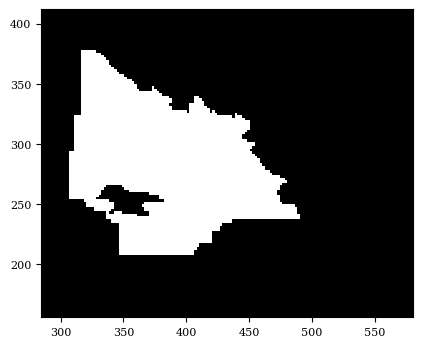

In [142]:
# -- Load permh property
permh = mm.prop['permh']

# -- Initiale Marthefield fill with NaN values
ipermh = MartheField('ipermh', np.nan, mm)

# -- Plot result on layer 6
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(6, 4))
ipermh.plot(ax=ax, layer=6, masked_values=[], cmap='Greys_r')
plt.delaxes(ax.get_figure().axes[1])

To set a `zpc` parametrisation, the user has to set to the related cells a **negative interger**. All the cells with the **same interger** form a **parameterisation zone** with a **uniform field value** (in this case _permeability_) throughout the zone.<br>
Let's take it slowly and define first a unique a unique `zpc` for all layers.

<Axes: >

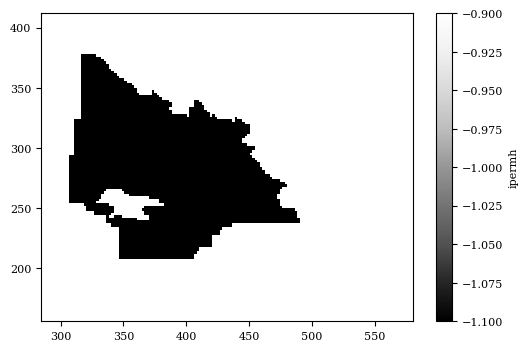

In [143]:
# -- Set unique zpc for all layers
ipermh.set_data(-1)

# -- Plot result on layer 6
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(6, 4))
ipermh.plot(ax=ax, layer=6, cmap='Greys_r')

<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> a shortcut for creating an <code>izone</code> object composed of a <code>zpc</code> parameterisation on all layers is to use the directly the <code>MartheField</code> constructor (<i>ex:<code>MartheField('izone', -1, mm, use_imask=True)</code></i>).
</div>

Now let's try to make  a more complex parameterisation on layer $13$ by spliting it into 4 `zpc` according to a **middle point** to finally produce: 

- **South West**: _`izone = -1`_
- **North West**: _`izone = -2`_
- **North East**: _`izone = -3`_
- **North East**: _`izone = -4`_


Text(0.5, 1.0, 'Multiple zpc parameterisation (layer 13)')

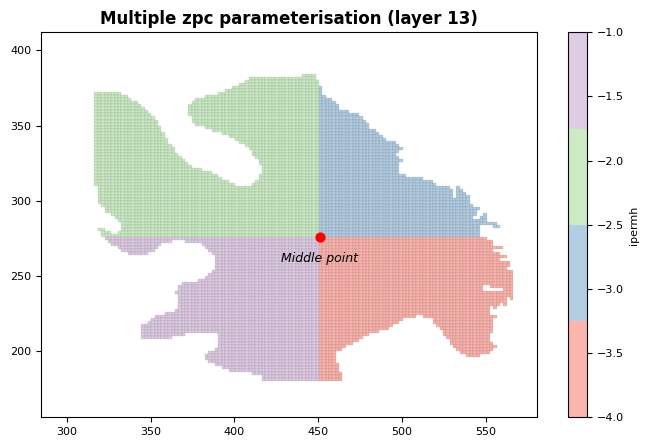

In [36]:
# -- Set split point coordinate
x, y, ilay = 451, 276, 13

# -- Get layer global mask
mask = ipermh.get_data(layer=ilay, masked_values=ipermh.dmv, as_mask=True)

# -- Extract cardinal mask
south, north = ipermh.data['y'] < y, ipermh.data['y'] > y
west, east = ipermh.data['x'] < x, ipermh.data['x'] > x

# -- Set zpc ids inplace
ipermh.data['value'][np.logical_and.reduce([mask, south, west])] = -1
ipermh.data['value'][np.logical_and.reduce([mask, north, west])] = -2
ipermh.data['value'][np.logical_and.reduce([mask, north, east])] = -3
ipermh.data['value'][np.logical_and.reduce([mask, south, east])] = -4

# -- Plot result on layer 13
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(8, 5))
ipermh.plot(ax=ax, layer=ilay, lw=.05, ec='k',
            cmap=ListedColormap(plt.cm.Pastel1.colors[:4]))

# -- Add middle point
ax.scatter(x, y, s=40, c='r')
ax.text(x, y - 10, 'Middle point',
        fontsize=9, fontstyle='italic',
        va='top', ha='center')

# -- Add title 
ax.set_title(f'Multiple zpc parameterisation (layer {ilay})',
             fontsize=12, fontweight='bold')

<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> remember that this sectorisation is for <b>educational purposes only</b> and makes absolutely no sense from a hydrogeological point of view!
</div>

Let's make a summary of all parametrised layers.

In [38]:
# -- zpc parametrisation summary
df = pd.DataFrame.from_records(ipermh.data)
(
    df
    .mask(df.value.isin(ipermh.dmv))
    .dropna()
    .groupby(['layer', 'value'])
    .size()
    .reset_index()
    .set_axis(['layer', 'zpc', 'ncells'], axis=1)
    .astype(int)
    .set_index(['layer', 'zpc'])
)

,,ncells
layer,zpc,
0,-1,2874
1,-1,2227
2,-1,3161
3,-1,4055
4,-1,3899
5,-1,4331
6,-1,4326
7,-1,4337
8,-1,6205


### ☛ Manage _**P**ilot **P**oints_ (`pp`)

The **Pilot Point method** is a widely used  technique in hydrogeological model calibration. It involves the selection of specific points, called _pilot points_, within the model domain where parameter values can be adjusted. These pilot points act as _'control points'_ that help refine the model's representation of the hydrogeological system.<br>
By strategically adjusting the pilot point parameter values, this method enable huge improvements in areas where the model performance is poor or uncertain. The method helps capture the **spatial heterogeneity** of hydrogeological properties.

The `MartheOptim` instance has the ability to manage pilot points parametrisation for field calibration. To define a zone that will be parametrised with pilot points the user has to set to the related cells in the `izone` field a **positive interger**.<br>
Let's try to add pilot point parametrisation for the layer $4$.

<Axes: >

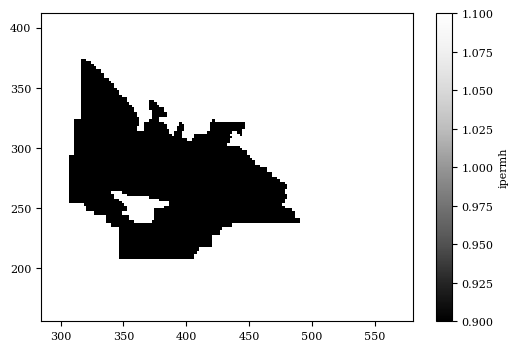

In [146]:
# -- Set unique pilot point zone for layer 4
ipermh.set_data(1, layer=4)

# -- Plot result on layer 4
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(6, 4))
ipermh.plot(ax=ax, layer=4, cmap='Greys_r')

In order to parametrise this zone, the user must provide the coordinates of required pilot points and store them in a python `dict`. This python dictionary will be named `pp_data` and has follow the following **format**:<br>

```python
pp_data = {
    
        layer_0 :{
                zone_1: ppobj_0,
                zone_2: ppobj_1,
                ...
                zone_K: ppobj_K
                },
    
        ...,
    
        layer_N :{
                zone_1: ppobj_0,
                zone_2: ppobj_1,
                ...
                zone_K: ppobj_K
                }
}


```

The `ppobj` correspond to '**p**ilot **p**oint **obj**ect', it can be:
- **Pilot Point coordinates**&emsp;➻&emsp; _`[[ppx_0, ppy_0], ..., [ppx_N, ppy_N]]`_
- **Path to a point shapefile**&emsp;➻&emsp;_`'gis/pp_layer_0.shp'`_


In [148]:
# -- Set/extract external pilot point coordinates
pp_shpfile = os.path.join(mm.mldir, 'gis', 'pp_l4.shp')
ppx, ppy = shp_utils.shp2points(pp_shpfile, stack=False)

# -- Build the pp_data object
pp_data = {4: {1: pp_shpfile}}  # layer 4, ppzone 1

Text(0.5, 1.0, 'Layer 4 parametrisation')

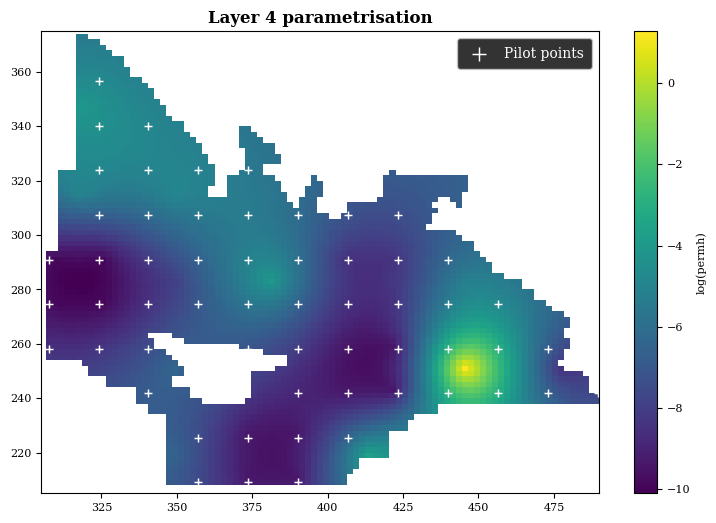

In [149]:
# -- Plot permh field (log)
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(9, 6))
permh.plot(ax=ax, layer=4, log=True, extent=(305, 205, 490, 375))

# -- Add pilot points
ax.scatter(ppx, ppy, s=40, marker='+', c='white', lw=1.05, label='Pilot points')
ax.legend(facecolor='k', labelcolor='w', fontsize=10, markerscale=1.5, borderpad=.6)

# -- Add title 
ax.set_title('Layer 4 parametrisation',
             fontsize=12, fontweight='bold')

### ☛ The `PilotPoints` instance

As we stated above, pilot points can come from **any external source**. However, parameterising model with large number of layers with very different and complex geometries, it can be quite restrictive to create all the pilot points **manually**. That the reason why a very usefull class called `PilotPoints` has been implemented in `PyMarthe` to facilitate the **generation of pilot points** compatible with `MartheOptim`.<br>

The `PilotPoints` tool can be initialised providing a **pre-filled** `izone` **field**.

<div class="alert alert-warning" role="alert">
    <span style="color: darkorange; font-size: 16px; font-weight: bold;">⚠ Warning: </span>
    <span style="color: darkorange;"> the <code>PilotPoints</code> tool requires additional <code>shapely</code> librairy. Make sure to install it properly (<code>!pip install shapely</code>).
</div>

In [150]:
# -- Initialize PilotPoints instance
pp = PilotPoints(izone=ipermh)

# -- Print basic infos
print('\t', pp, '\n', '-'*30)
print('Actual pilot points data:', pp.data)

	 PilotPoints 
 ------------------------------
Actual pilot points data: {4: {1: None}}


The `PilotPoint` instance can be used to generate pilot points either by specifying:<br>

&emsp;&emsp;➼ _**xy-spacing**_ between points: `.add_spacing_pp()` (_to control the **experimental variagram** used during **kriging process**_)<br>
&emsp;&emsp;➼ _**fixed number**_ of pilot points: `.add_n_pp()` (_to control the number of parameters during **calibration process**_)<br>

<p style="color: #DB7093; font-size:1.2em;">📍 <i><code>spacing</code></i> generator</p>

In [7]:
# -- Set spacing
dx, dy = 13, 10 # in model distance unit (= km)

# -- Generate pilot points
pp.add_spacing_pp(layer=4, zone=1,
                  xspacing=dx, yspacing=dy,
                  xoffset=0, yoffset=0)

# -- Print added pilot points
pp.data

{4: {1: {'layer': 4,
   'zone': 1,
   'xspacing': 13,
   'yspacing': 10,
   'xoffset': 0,
   'yoffset': 0,
   'buffer': 0,
   'n': 133,
   'pp': <MULTIPOINT (306.5 258, 306.5 268, 306.5 278, 306.5 288, 319.5 258, 319.5 26...>}}}

The generated objet correspond to a python dictonary with **meta data** i.e. data provided for the points creation such as `layer`, `zone`, `xspacing`, ... and **pp data** (`pp`) which corresponds to a `MULTIPOINT` shapely object.<br>

The `PilotPoints` instance also provide a internal `.plot()` method to have a better look on generated points.

<Axes: title={'center': 'Pilot Points (layer 4, zone 1)'}>

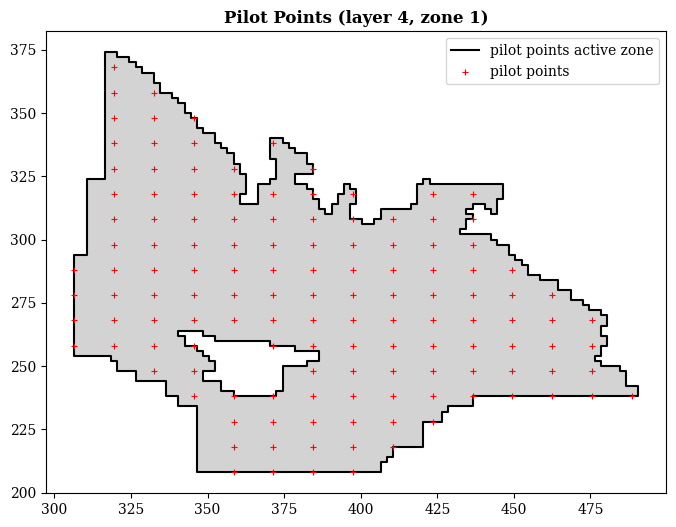

In [9]:
# -- Plot generated points
pp.plot(layer=4, zone=1)

Sometimes **aquifer geometry** can more complex and the user may wish to **exaggerate** the extension of the active zone in order to generate pilot points beyond the active zone to improve **interpolation by kriging**. This can be done with the `PilotPoint` instance by specifying a **buffer zone** around the active zone using the `buffer` argument.<br>

Let's try it out.

<Axes: title={'center': 'Pilot Points (layer 4, zone 1)'}>

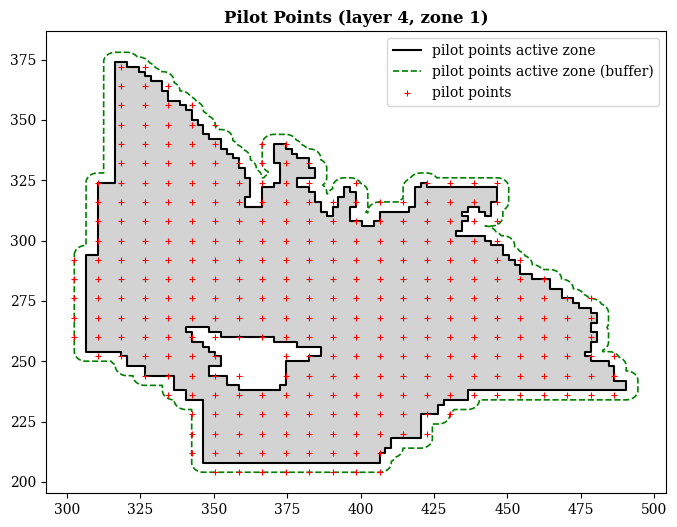

In [37]:
# -- Set spacing
dx, dy, buffer = 8, 8, 4 # in model distance unit (= km)

# -- Generate pilot points (with buffer)
pp.add_spacing_pp(layer=4, zone=1,
                  xspacing=dx, yspacing=dy,
                  xoffset=0, yoffset=0, buffer=buffer)

# -- Plot generated points
pp.plot(layer=4, zone=1, buffer=buffer)

<div class="alert alert-danger" role="alert">
    <span style="color: red; font-size: 16px; font-weight: bold;">⛔ CAREFUL: </span>
    <span style="color: darkred;"> using <code>buffer</code> will probably generate pilot points <b>outside the zone extension</b> wich can produce an issue while sampling the parameters <code>defaultvalue</code> during parameter implementation. We are currently working on ways to avoid the problems caused by this particular case and <b>recommend not using</b> the <code>buffer</code> with the current version of <code>PyMarthe</code>.
    </span>
</div>

<p style="color: #DB7093; font-size:1.2em;">📍 <i><code>fixed</code></i> generator</p>

In [151]:
# -- Set number of pilot points
N = 75

# -- Generate pilot points
pp.add_n_pp(layer=4, zone=1, n=N, tol=.1)

# -- Print added pilot points
pp.data

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\utils\shp_utils.py:96: RuntimeWarning: invalid value encountered in divide
C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\utils\shp_utils.py:96: RuntimeWarning: divide by zero encountered in divide


{4: {1: {'layer': 4,
   'zone': 1,
   'n': 75,
   'tol': 0.1,
   'xoffset': 0,
   'yoffset': 0,
   'buffer': 0,
   'xspacing': 14.299999999999645,
   'yspacing': 14.299999999999645,
   'pp': <MULTIPOINT (320.9 265.6, 320.9 280, 320.9 294.4, 320.9 308.8, 320.9 323.2, ...>}}}

<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> generating <code>n</code> points in parametrised zone is performed by infering <b>regular space</b> between points using an <b>iterative approach</b> according to the given <b>tolerance</b> (<code>tol</code>, <i>in model distance unit</i>). A <b>low value</b> can slow down the points generation but offers a better precision (match exactly the required number of pilot points). 
</div>

<Axes: title={'center': 'Pilot Points (layer 4, zone 1)'}>

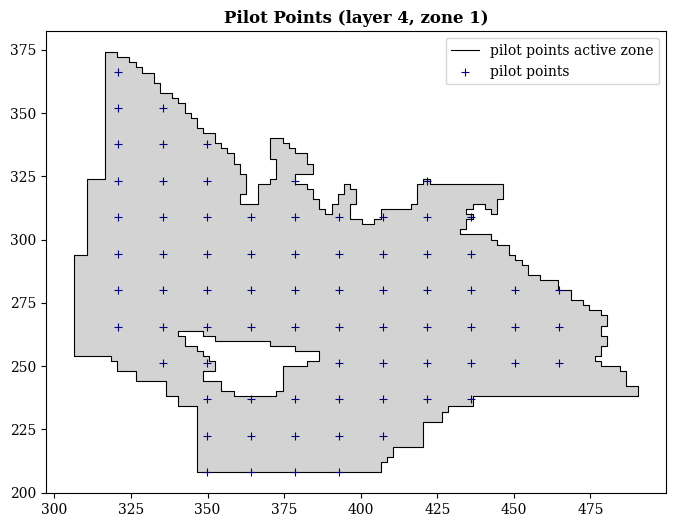

In [25]:
# -- Plot N generated points
pp.plot(layer=4, zone=1, pp_kwargs={'s': 32, 'color':'navy'}, zone_kwargs={'lw': .8})

<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> all generated pilot points can be <b>written on disk</b> as <i>shapefile</i> using the internal <code>.to_shapefile()</code>.
</div>

<span style="font-size: 2em;">🔎
</span>
<span>Sometimes it can be hard to find the correct <b>variogram range</b> to use for the <b>kriging interpolation</b>. It highly depends on pilot point location. Several modellers agree that one of the best practices to adopt is to define the range of the variagram in proportion to the <b>maximum distance between two neighbouring pilot points</b>:
</span>

<div style="align: center; font-size: 20px; padding-top: 12px;">
    $$variagram\_range = factor \times min(D_{neighbours\_pp})$$
</div>

The `PilotPoints` instance provides a internal method `.extract_vgm_range()` to make this process easier!

In [51]:
# -- Extract variogram range
print('\tInfered Variogram Ranges', '\n', '-'*30)
for f in range(2, 6):
    print(f'Factor = {f} ==>', pp.extract_vgm_range(factor=f))

	Infered Variogram Ranges 
 ------------------------------
Factor = 2 ==> {4: {1: 16}}
Factor = 3 ==> {4: {1: 24}}
Factor = 4 ==> {4: {1: 32}}
Factor = 5 ==> {4: {1: 40}}


Once the pilot points have been generated, they need to be converted into an `pp_data` object to be compatible with `MartheGridParam` instance. To do so, consider using the `.to_pp_data()` method.

In [40]:
# -- Converting generated pilot points to pp_data object
pp.to_pp_data()

{4: {1: [[302.5, 260.0],
   [302.5, 268.0],
   [302.5, 276.0],
   [302.5, 284.0],
   [302.5, 292.0],
   [310.5, 252.0],
   [310.5, 260.0],
   [310.5, 268.0],
   [310.5, 276.0],
   [310.5, 284.0],
   [310.5, 292.0],
   [310.5, 300.0],
   [310.5, 308.0],
   [310.5, 316.0],
   [310.5, 324.0],
   [318.5, 252.0],
   [318.5, 260.0],
   [318.5, 268.0],
   [318.5, 276.0],
   [318.5, 284.0],
   [318.5, 292.0],
   [318.5, 300.0],
   [318.5, 308.0],
   [318.5, 316.0],
   [318.5, 324.0],
   [318.5, 332.0],
   [318.5, 340.0],
   [318.5, 348.0],
   [318.5, 356.0],
   [318.5, 364.0],
   [318.5, 372.0],
   [326.5, 244.0],
   [326.5, 252.0],
   [326.5, 260.0],
   [326.5, 268.0],
   [326.5, 276.0],
   [326.5, 284.0],
   [326.5, 292.0],
   [326.5, 300.0],
   [326.5, 308.0],
   [326.5, 316.0],
   [326.5, 324.0],
   [326.5, 332.0],
   [326.5, 340.0],
   [326.5, 348.0],
   [326.5, 356.0],
   [326.5, 364.0],
   [326.5, 372.0],
   [334.5, 236.0],
   [334.5, 244.0],
   [334.5, 252.0],
   [334.5, 260.0],
   [33

### ☛ Add parameters

Next, to add a `grid-like` set of parameters in the main `MartheOptim` instance, consider unsing the `.add_param()` method. This will create a new `MartheGridParam`  instance in the parameter storage `.param`. Remember that by default, if no `izone` argument is specified, a basic one with a unqiue `zpc` parametrisation for all layers will be considered.<br>

If at least one zone is parametrised as **pilot points**, make sure to specify the right `pp_data` object to set informations about points coordinates. Let's focus on **hydraulic permeability** (_ex: `hk`_) property only and try to add it as parameter.

In [102]:
# -- Without `izone`
mopt.remove_param(parname='hk')
mopt.add_param(parname='hk', mobj=permh)

# -- Show results
print('Parameter type:', mopt.param['hk'].type)
print('Parameter storage:\n', mopt.param)
print('Parameter data:')
mopt.get_param_df().head(5)

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\mparam.py:427: UserWarning: WARNING : no `izone` provided. A generic one will be created  from the `permh` field with a unique zpc zone  (in active cells) for each layer.


Parameter type: grid
Parameter storage:
 {'hk': <pymarthe.mparam.MartheGridParam object at 0x000001779A0F9FF0>}
Parameter data:


,parnme,trans,btrans,parchglim,defaultvalue,parlbnd,parubnd,pargp,scale,offset,dercom
parname,,,,,,,,,,,
hk_zpc_l01_z01,hk_zpc_l01_z01,none,none,factor,0.004578,1.000000e-10,1.000000e+10,hk_zpc,1,0,1
hk_zpc_l02_z01,hk_zpc_l02_z01,none,none,factor,0.012281,1.000000e-10,1.000000e+10,hk_zpc,1,0,1
hk_zpc_l03_z01,hk_zpc_l03_z01,none,none,factor,0.000110,1.000000e-10,1.000000e+10,hk_zpc,1,0,1
hk_zpc_l04_z01,hk_zpc_l04_z01,none,none,factor,0.000052,1.000000e-10,1.000000e+10,hk_zpc,1,0,1
hk_zpc_l05_z01,hk_zpc_l05_z01,none,none,factor,0.010701,1.000000e-10,1.000000e+10,hk_zpc,1,0,1


In [103]:
# -- With `izone` but without pilot point information
mopt.remove_param(parname='hk')
mopt.add_param(parname='hk', mobj=permh, izone=ipermh)

# -- Show results
print('Parameter storage:\n', mopt.param)
print('Parameter data:')
mopt.get_param_df().sample(5)

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\mparam.py:635: UserWarning: WARNING : pilot point coordinates not provided for layer = 4 and zone = 1. Default pilot points will be generated.


Parameter storage:
 {'hk': <pymarthe.mparam.MartheGridParam object at 0x000001779A3EA1D0>}
Parameter data:


,parnme,trans,btrans,parchglim,defaultvalue,parlbnd,parubnd,pargp,scale,offset,dercom
parname,,,,,,,,,,,
hk_l05_z01_43,hk_l05_z01_43,none,none,factor,1.482100e-07,1.000000e-10,1.000000e+10,hk_pp,1,0,1
hk_l05_z01_26,hk_l05_z01_26,none,none,factor,1.079237e-07,1.000000e-10,1.000000e+10,hk_pp,1,0,1
hk_l05_z01_29,hk_l05_z01_29,none,none,factor,2.663800e-09,1.000000e-10,1.000000e+10,hk_pp,1,0,1
hk_l05_z01_33,hk_l05_z01_33,none,none,factor,2.618843e-09,1.000000e-10,1.000000e+10,hk_pp,1,0,1
hk_l05_z01_04,hk_l05_z01_04,none,none,factor,1.037973e-05,1.000000e-10,1.000000e+10,hk_pp,1,0,1


As the `list-like parmeters` discussed above, some others arguments (`**kwargs`) can be implemented while adding parameters such as `defaultvalue`, `parchglim`, `parlbnd`, `parubnd`, `pargp`, `scale`, ...<br>

So, a global `defaultvalue` can be provided easily by the user, otherwise, the **prior / initial values** will be taken from the current `mobj` field as:<br>

&emsp;&emsp;➼&emsp;**zonal mean field** value for `zpc`<br>
&emsp;&emsp;➼&emsp;**sampled field** value for `pp`<br>

In [104]:
# -- With `izone`, pilot point data, setting all initial values to 0.001
mopt.remove_param(parname='hk')
mopt.add_param(parname='hk',
               mobj=permh,
               izone=ipermh,
               pp_data=pp.to_pp_data(),
               defaultvalue=1e-3)

# -- Show results
print('Parameter storage:\n', mopt.param)
print('Parameter data:')
mopt.get_param_df().sample(5)

Parameter storage:
 {'hk': <pymarthe.mparam.MartheGridParam object at 0x000001779C9232B0>}
Parameter data:


,parnme,trans,btrans,parchglim,defaultvalue,parlbnd,parubnd,pargp,scale,offset,dercom
parname,,,,,,,,,,,
hk_l05_z01_032,hk_l05_z01_032,none,none,factor,0.001,1.000000e-10,1.000000e+10,hk_pp,1,0,1
hk_l05_z01_119,hk_l05_z01_119,none,none,factor,0.001,1.000000e-10,1.000000e+10,hk_pp,1,0,1
hk_l05_z01_112,hk_l05_z01_112,none,none,factor,0.001,1.000000e-10,1.000000e+10,hk_pp,1,0,1
hk_l05_z01_022,hk_l05_z01_022,none,none,factor,0.001,1.000000e-10,1.000000e+10,hk_pp,1,0,1
hk_l05_z01_136,hk_l05_z01_136,none,none,factor,0.001,1.000000e-10,1.000000e+10,hk_pp,1,0,1


In [105]:
# -- With `izone`, pilot point data and constrain bounds
mopt.remove_param(parname='hk')
mopt.add_param(parname='hk',
               mobj=permh,
               izone=ipermh,
               pp_data=pp.to_pp_data(),
               parlbnd=1e-9,
               parubnd=5e-1)

# -- Show results
print('Parameter storage:\n', mopt.param)
print('Parameter data:')
mopt.get_param_df().sample(5)

Parameter storage:
 {'hk': <pymarthe.mparam.MartheGridParam object at 0x000001779BBA6E60>}
Parameter data:


C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\mparam.py:791: UserWarning: WARNINGS : could not extract field data properly at pilot points coordinates.  for `layer`=4 and `zone`=1. The reason can be the:
	- Absence of spatial index in main model
	- Bad spatial index files creation
	- Presence of corrupted spatial index files
	- Pilot point(s) location outside the current zone
The mean field value on this zone will be set as `default_value` instead.


,parnme,trans,btrans,parchglim,defaultvalue,parlbnd,parubnd,pargp,scale,offset,dercom
parname,,,,,,,,,,,
hk_l05_z01_281,hk_l05_z01_281,none,none,factor,0.010701,1.000000e-09,0.5,hk_pp,1,0,1
hk_l05_z01_184,hk_l05_z01_184,none,none,factor,0.010701,1.000000e-09,0.5,hk_pp,1,0,1
hk_l05_z01_303,hk_l05_z01_303,none,none,factor,0.010701,1.000000e-09,0.5,hk_pp,1,0,1
hk_l05_z01_254,hk_l05_z01_254,none,none,factor,0.010701,1.000000e-09,0.5,hk_pp,1,0,1
hk_l05_z01_051,hk_l05_z01_051,none,none,factor,0.010701,1.000000e-09,0.5,hk_pp,1,0,1


<div class="alert alert-warning" role="alert">
    <span style="color: darkorange; font-size: 16px; font-weight: bold;">⚠ Warning: </span>
    <span style="color: darkorange;"> if the <b>sampling process</b> cannot be performed on all pilot points, then the considered <code>defaultvalue</code> will be set to the <b>mean</b> value of the entire zone.
</div>

### ☛ Apply transformations

`Martheoptim` instance allows the user to apply **any type of transformation** on parameter data. One of the major advantages of `PyMarthe` about the transformation of parameter values is that all transformations are managed **in** and **by** the library. Thus, all values given to **PEST** will correspond to **pre-transformed** data. This allows **extreme flexibility** in terms of control and **scaling effects**. However, the user must take care to maintain **continuity** in the parameter transformations, that is the reason why, unlike observations, when implementing a transformation it is also necessary to fill in the **inverse trasnformation** (also known as **back-transformation**) in order to modify the model properties only with **untransformed data**!

The transformation can be specified:<br>

&emsp;&emsp;<span style="font-size: 20px">➀</span> **During** parameter implementation (`trans` & `btrans` arguments)<br>
&emsp;&emsp;<span style="font-size: 20px">➁</span> **After** parameter implementation (`.set_param_trans()` method)<br>

The transformation to apply **must be valid** otherwise an error will be raised. It can be a:

- **Basic `str` function**: _`'log10'`_, _`'sqrt'`_, ...
- **Evaluable callable**: _`'lambda x: 10**(x + 1)'`_, _`'lambda x: -x'`_, ...

In [154]:
# -- Adding parameter with log transformations (1)
mopt.remove_param(parname='hk')
mopt.add_param(parname='hk',
               mobj=permh,
               izone=ipermh,
               pp_data=pp.to_pp_data(),
               defaultvalue=1e-3,
               trans='log10',                # transformation
               btrans='lambda x: 10**x')     # back-transformation

# -- Show results
print('Parameter data:')
mopt.get_param_df(transformed=True).sample(5)

Parameter data:


C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt


,parnme,trans,btrans,parchglim,defaultvalue,parlbnd,parubnd,pargp,scale,offset,dercom
hk_l05_z01_12,hk_l05_z01_12,log10,lambda x: 10**x,factor,-3.0,-1.000000e+01,1.000000e+01,hk_pp,1,0,1
hk_zpc_l02_z01,hk_zpc_l02_z01,log10,lambda x: 10**x,factor,-3.0,-1.000000e+01,1.000000e+01,hk_zpc,1,0,1
hk_zpc_l11_z01,hk_zpc_l11_z01,log10,lambda x: 10**x,factor,-3.0,-1.000000e+01,1.000000e+01,hk_zpc,1,0,1
aqpump_031686__1__11,aqpump_031686__1__11,none,none,factor,-21.9,1.000000e-10,1.000000e+10,aqpump_031686,1,0,1
aqpump_035533__1__28,aqpump_035533__1__28,sqrt,lambda x: x**2,factor,NaN,1.000000e-05,1.000000e+05,aqpump_035533,1,0,1


In [123]:
mopt.set_param_trans(trans='sqrt', btrans='lambda x: x**2', parname=['hk_l05_z01_000', 'hk_l05_z01_000'])

In [131]:
# -- Apply transformation a posteriori (2)
mopt.set_param_trans(trans='sqrt', btrans='lambda x: x**2')

# -- See results
(
    mopt
    .get_param_df()
    .groupby('pargp')
    .agg({'trans': 'first', 'btrans': 'first'})
)

,trans,btrans
pargp,,
hk_pp,sqrt,lambda x: x**2


<div class="alert alert-danger" role="alert">
    <span style="color: red; font-size: 16px; font-weight: bold;">⛔ CAREFUL: </span>
    <span style="color: darkred;"> <code>PyMarthe</code> only accepts <b>ONE transformation / back-transformation per parametrised field</b>.
    </span>
</div>

## 👉 Write _par_ / _tpl_ files

To write basic **parameter** files (_.dat_) and **template** (_.tpl_) files from the `MartheOptim` instance consider using the appropriate writing functions (can be performed for a single, a group or all paramaters). The **default values** of each parameter will be written in a distinct parameter file according to the user transformation.

In [165]:
# -- Reset all transformations
mopt.set_param_trans('none', 'none')

# -- Write all parameter files
mopt.write_parfile()

# -- Write all template files
mopt.write_tplfile()

The output **parameter** files for **pilot points parameters** correspond to a 5 columns _.dat_ file:
1. **parameter names**
2. **x-coordinates** _(pilot points)_
3. **y-coordinates** _(pilot points)_
4. **zone ids**
5. **parameter values**

In [166]:
# -- Print par file (pilot point)
!head -n 5 'monav3/pest/par/hk_pp_l05_z01.dat'

hk_l05_z01_00 3.2090000000E+02      2.6560000000E+02      1           1.0000000000E-03     
hk_l05_z01_01 3.2090000000E+02      2.8000000000E+02      1           1.0000000000E-03     
hk_l05_z01_02 3.2090000000E+02      2.9440000000E+02      1           1.0000000000E-03     
hk_l05_z01_03 3.2090000000E+02      3.0880000000E+02      1           1.0000000000E-03     
hk_l05_z01_04 3.2090000000E+02      3.2320000000E+02      1           1.0000000000E-03     


In [184]:
# -- Print tpl file (pilot point)
!head -n 5 'monav3/pest/tpl/hk_pp_l05_z01.tpl'

ptf ~
hk_l05_z01_00 3.2090000000E+02      2.6560000000E+02      1            ~hk_l05_z01_00~      
hk_l05_z01_01 3.2090000000E+02      2.8000000000E+02      1            ~hk_l05_z01_01~      
hk_l05_z01_02 3.2090000000E+02      2.9440000000E+02      1            ~hk_l05_z01_02~      
hk_l05_z01_03 3.2090000000E+02      3.0880000000E+02      1            ~hk_l05_z01_03~      


The output **parameter** files for **zpc** and all `list-like` **parameters** correspond to a 2 columns _.dat_ file:
1. **parameter names**
2. **parameter values**

In [170]:
# -- Print par file (zpc)
!head -n 5 'monav3/pest/par/hk_zpc.dat'

hk_zpc_l01_z01 1.0000000000E-03     
hk_zpc_l02_z01 1.0000000000E-03     
hk_zpc_l03_z01 1.0000000000E-03     
hk_zpc_l04_z01 1.0000000000E-03     
hk_zpc_l06_z01 1.0000000000E-03     


In [185]:
# -- Print tpl file (zpc)
!head -n 5 'monav3/pest/tpl/hk_zpc.tpl'

ptf ~
hk_zpc_l01_z01  ~hk_zpc_l01_z01~     
hk_zpc_l02_z01  ~hk_zpc_l02_z01~     
hk_zpc_l03_z01  ~hk_zpc_l03_z01~     
hk_zpc_l04_z01  ~hk_zpc_l04_z01~     


In [173]:
# -- Print created file (aquifer pumping)
!tail -n 5 'monav3/pest/par/aqpump_031686.dat'

 aqpump_031686__1__35  -2.1900000000E+01    
 aqpump_031686__1__36  -2.1900000000E+01    
 aqpump_031686__1__37  -2.1900000000E+01    
 aqpump_031686__1__38  -2.1900000000E+01    
 aqpump_031686__1__39  -2.1900000000E+01    


In [186]:
# -- Print tpl file (zpc)
!head -n 5 'monav3/pest/tpl/aqpump_031686.tpl'

ptf ~
 aqpump_031686__1__0    ~aqpump_031686_1_0~  
 aqpump_031686__1__1    ~aqpump_031686_1_1~  
 aqpump_031686__1__2    ~aqpump_031686_1_2~  
 aqpump_031686__1__3    ~aqpump_031686_1_3~  


## 👉 Write kriging factor files

If `izone` contains pilot point zone(s), it's necessary to compute and store **the kriging factors** in order to perform **ordinary kriging** between pilot points and be able to set **interpolated field values** into each required grid cells.
To do so, consider using the `.write_kriging_factors()` method. It is a simple wrapper to the `pyemu.utils.geostats.OrdinaryKrige.calc_factors()`. The goal is to write a _PEST-like_ kriging factor files (_.fac_) given the ranges of **exponential variograms** (argument `vgm_range`) for each layer and zone of pilot points.

In [178]:
# Valid range input
mopt.write_kriging_factors(vgm_range=pp.extract_vgm_range(factor=2), parname='hk')

starting interp point loop for 3899 points
starting 0
starting 1
starting 2
starting 3
took 11.515228 seconds
OrdinaryKrige.to_grid_factors_file(): spatial_reference attr is None, assuming unstructured grid


<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> setting <code>save_cov=True</code> will automatically save the computed <b>covariance matrix</b> as binary file (readable with <code>pyemu.Cov</code>).
</div>

In [183]:
# -- Print fac file (pilot point)
!head -n 10 'monav3/pest/par/hk_pp_l05_z01.fac'
!tail -n 5 'monav3/pest/par/hk_pp_l05_z01.fac'

points.junk
zone.junk
3899 1
75
hk_l05_z01_00
hk_l05_z01_01
hk_l05_z01_02
hk_l05_z01_03
hk_l05_z01_04
hk_l05_z01_05
3895 0 13 0.00000e+00 42   0.69987195 43  0.092026316 50   0.15797269 27 0.0023609058 57 0.0041937961 45 0.00014356825 29 0.0014258691 64  0.017132984 17 0.0074376344 58 0.0014971736 18 0.0018826687 19 0.0063994968 46 0.0076549548 
3896 0 12 0.00000e+00 42   0.61229796 43  0.092159811 50   0.22003402 27 0.0039501438 57 0.0074804675 45 0.00041652736 29 0.0059219068 64  0.022558447 17  0.010681321 18 0.0064454291 65 0.0070755941 46  0.010978377 
3897 0 12 0.00000e+00 42   0.53569313 50   0.27652859 43  0.083237847 57  0.012301112 27 0.0054750868 45 0.0046260832 64  0.030719778 29 0.0082385565 17  0.013688506 18 0.0083497381 65 0.0083463465 53  0.012795233 
3898 0 12 0.00000e+00 42   0.47165586 50   0.32672984 43  0.069309007 57  0.018513062 27 0.0068184053 64  0.039654116 45  0.005661577 29 0.0099942022 65 0.0097094883 17  0.016451123 18  0.010113973 53  0.015389345 
3899 0

# 🎇 **`PEST` interfacing** 🎇

Once we have transformed the **model properties** into **parameters** and written the related **PEST** files, we need to save the **current parameterisation**, generate the model **launch script** and **algorithm control** files to finally start the calibration / optimisation process.<br>

Let's build a reduced example of parametrisation setup.

In [5]:
# -- 1) Build MartheOptim object
mopt = MartheOptim(mm, name='opti_mona', **pest_dirs)

# -- 2) Implement observation data
ext_file = os.path.join(mm.mldir, 'obs', '07065X0002.dat')
mopt.add_obs(data=ext_file, datatype='head')

# -- 3) Add fluctuations
mopt.add_fluc(locnme='07065X0002', tag='mn', on='mean')

# -- 4) Add list-like parameter
mm.load_prop('aqpump', verbose=False)
kmi = pest_utils.get_kmi(mobj=mm.prop['aqpump'], keys=['boundname', 'layer', 'istep'], boundname='aqpump_035533', layer=1)
mopt.add_param(parname='aqpump_035533', mobj=mm.prop['aqpump'], kmi=kmi, defaultvalue=-35)

# -- 5) Add grid-like parameter
ipermh = MartheField('ipermh', -1, mm, use_imask=True)       # build basic izone (zpc on all layer)
ipermh.set_data(1, layer=4)                                  # enable pilot points parametrisation on layer 4
pp = PilotPoints(izone=ipermh)                               # initialize pilot point manager
pp.add_spacing_pp(layer=4, zone=1, xspacing=13, yspacing=10) # seed pilot points from xy-spacing
mopt.add_param(parname='hk', mobj=mm.prop['permh'], izone=ipermh,
               pp_data=pp.to_pp_data(), defaultvalue=1e-3,
               trans='log10', btrans='lambda x: 10**x')      # add parameterised permeability      

# -- 6) Write files
mopt.write_insfile()
mopt.write_simfile()
mopt.write_parfile()
mopt.write_tplfile()
mopt.write_kriging_factors(vgm_range=pp.extract_vgm_range(factor=2))

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\utils\shp_utils.py:96: RuntimeWarning: invalid value encountered in divide
C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\utils\shp_utils.py:96: RuntimeWarning: divide by zero encountered in divide


starting interp point loop for 3899 points
starting 0
starting 1
starting 2
starting 3
took 9.646379 seconds
OrdinaryKrige.to_grid_factors_file(): spatial_reference attr is None, assuming unstructured grid


## 👉 Configuration

`MartheOptim` can easily generate and write a text file containing all the necessary information about the **current parametrisation**. This external text file, _.config_, will be used during the **forward run** process by instantialized a `MartheModel` instance **transforming back** the parameters into model properties (with _changed_/_optimized values_). 
The configuration file **keep only** the essential informations, it is organised into 3 distinct parts:<br>

&emsp;&emsp;➼<b>Title</b> : file title with creation timestamp<br>
&emsp;&emsp;➼<b>Headers</b> : general informations about parametrisation (<i>model paths</i>, <i>spatial index</i>, <i>number of observation sets</i>, <i>number of parmeter sets</i>, ...)<br>
&emsp;&emsp;➼<b>Observation sections</b> : blocks of informations about observation data. Each block is delimited by a:<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;➢ _**start tag**_ : `[START_OBS]`<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;➢ _**end tag**_ : `[END_OBS]`<br>
&emsp;&emsp;➼<b>Parameter sections</b> : blocks of informations about parameter data. Each block is delimited by a:<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;➢ _**start tag**_ : `[START_PARAM]`<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;➢ _**end tag**_ : `[END_PARAM]`<br>

<p align="left">
  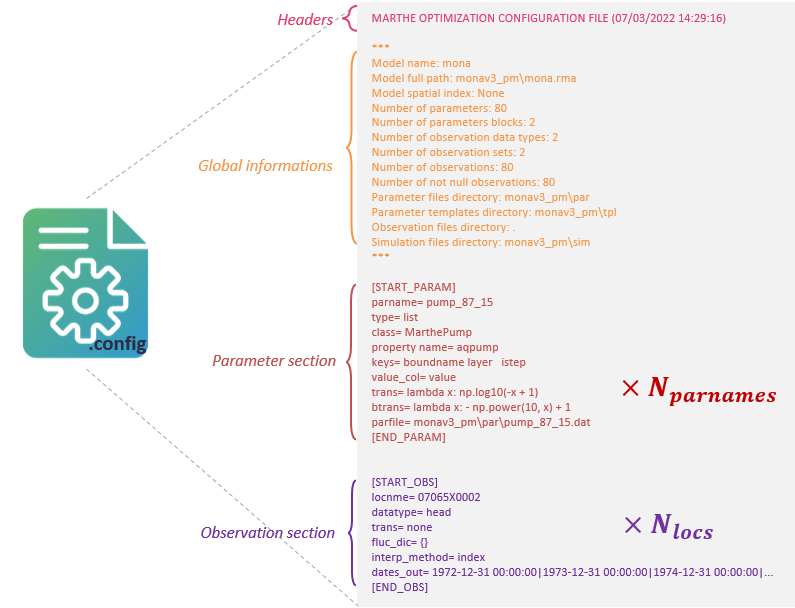
</p>


In [6]:
# -- Save/write parametrisation configuration
configfile = os.path.join(mm.mldir, 'opti_mona.config')
mopt.write_config(configfile)

# -- See results
!head monav3/opti_mona.config -n 30

MARTHE OPTIMIZATION CONFIGURATION FILE (08/07/2023 13:43:19)

***
Model name: mona
Model full path: monav3\mona.rma
Model spatial index: monav3\mona_si
Number of parameters: 187
Number of parameters blocks: 2
Number of observation data types: 2
Number of observation blocks: 2
Number of observations: 80
Number of not null observations: 80
Parameter files directory: monav3\pest\par
Parameter templates directory: monav3\pest\tpl
Observation files directory: .
Simulation files directory: monav3\pest\sim
***

[START_PARAM]
parname= aqpump_035533
type= list
class= MarthePump
property name= aqpump
keys= boundname,layer,istep
value_col= value
trans= none
btrans= none
parfile= monav3\pest\par\aqpump_035533.dat
[END_PARAM]



The main advantage of saving the parameter configuration is that the user can load a `MartheModel` instance from it. In other words, it will load the parametrised properties of a **Marthe** model and **set data from parameter files**.
As a example, the user can mimic the **PEST** algorithm behaviour and change some values in a given parameter file and check _a posteriori_ the related model property values after loading the model with the specific **class method** `MartheModel.from_config()`.

In [214]:
# -- Let's retrieve a MartheModel instance from generated config file
mm_from_config = MartheModel.from_config(configfile)

# -- See loaded properties
mm_from_config.prop

C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\mpump.py:88: UserWarning: Pumping condition applied on inactive cell : Node = 26813, Layer = 1, Nested = 0, Row = 53, Column = 25 .
C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\mpump.py:88: UserWarning: Pumping condition applied on inactive cell : Node = 105550, Layer = 5, Nested = 0, Row = 73, Column = 26 .
C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\mpump.py:88: UserWarning: Pumping condition applied on inactive cell : Node = 4911, Layer = 0, Nested = 0, Row = 33, Column = 27 .
C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\mpump.py:88: UserWarning: Pumping condition applied on inactive cell : Node = 105551, Layer = 5, Nested = 0, Row = 73, Column = 27 .
C:\Users\pierr\OneDrive\Documents\dev\adeqwat\examples\..\pymarthe\mpump.py:88: UserWarning: Pumping condition applied on inactive cell : Node = 27114, Layer = 1, Nested = 0, Row = 55, Column = 30 .
C:\U

{'permh': <pymarthe.mfield.MartheField at 0x1779d70f550>,
 'aqpump': <pymarthe.mpump.MarthePump at 0x177be077fd0>}

As expected the `mm_from_config` object already contains the model properties that had been parametrised earlier (with `defaultvalue`).

In [211]:
# -- Check permh layer 1 unique values (must be [0.001] = set default value)
np.unique(mm_from_config.prop['permh'].get_data(layer=1, masked_values=[0])['value'])

array([0.001])

In [215]:
# -- Check aquifer pumping value (must be [-35])
np.unique(mm_from_config.prop['aqpump'].get_data(boundname='aqpump_035533', layer=1)['value'])

array([-35.])

## 👉 Forward run

During calibration or optimization, the **PEST** algorithms will run the **Marthe** model several times in order to assess the _observed_ / _simulated_ **residuals** for a given set of parameters. In general, the modeler should provides the **command** or **script** required to run the model. It turns out that `MartheOptim` is equiped with a wonderful internal method for generating model run scripts (**forward run**). It will implicitly uses the `pest_utils.run_from_config()` function to build `MartheModel` instance from configuration file and automatically run it!<br>

Let's dig deeper into it and try to write a **forward run script**.

In [236]:
# -- Write standard forward run file
fr_file = os.path.join(mm.mldir, 'forward_run.py')
mopt.write_forward_run(fr_file=fr_file, configfile=configfile, exe_name='Marth_R8')

# -- See created python script
!tail -n +11 monav3/forward_run.py


# -- Import basic python modules
import os
import pyemu
import multiprocessing as mp
import numpy as np
import pandas as pd
import pymarthe



def main():
	# -- Run model from .config file
	pymarthe.utils.pest_utils.run_from_config("monav3\opti_mona.config", exe_name="Marth_R8")
	# -- Run extra functions


# -- Launch forward run
if __name__ == '__main__':
	mp.freeze_support()
	main()



The user can also provides other (_extra_) **post-processing functions** to run after (re)running the model. It make the feature much more **flexible**! Let's try it out.

In [238]:
# -- Write forward run with extra basics functions
def foo():
    s = 'get upper case'
    return s.upper()

def bar():
    return glob.glob('.')

def get_local_object():
    if 'something' in locals():
        return locals()['something']
    else:
        raise ValueError('Nothing.')
        
# -- Rewrite forward run
mopt.write_forward_run(fr_file, configfile,
                       extra_py_imports='glob',                       # additional python package to import
                       extra_functions=[foo, bar, get_local_object],  # additional python functions to run
                       exe_name='Marth_R8')

# -- See created python script
!tail -n +11 monav3/forward_run.py


# -- Import basic python modules
import os
import pyemu
import multiprocessing as mp
import numpy as np
import pandas as pd
import pymarthe

# -- Import extra python modules
import glob

# -- Extra function nÂ°1
def foo():
    s = 'get upper case'
    return s.upper()

# -- Extra function nÂ°2
def bar():
    return glob.glob('.')

# -- Extra function nÂ°3
def get_local_object():
    if 'something' in locals():
        return locals()['something']
    else:
        raise ValueError('Nothing.')


def main():
	# -- Run model from .config file
	pymarthe.utils.pest_utils.run_from_config("monav3\opti_mona.config", exe_name="Marth_R8")
	# -- Run extra functions
	foo()
	bar()
	get_local_object()


# -- Launch forward run
if __name__ == '__main__':
	mp.freeze_support()
	main()



## 👉 PEST control

**PEST** algorithms (`pestpp-glm`, `pestpp-ies`, `pestpp-cmaes`, `pestpp-opt`, ...) are manage from a specific file to control each options for a given _calibration_ / _optimisation_: the Pest Control File (_.pst_). The `pyemu` librairy is a wonderfull python _wrapper_ to build a custom **pst** easily. `MartheOptim` instance has a specific method named `.build_pst()` that use the `pyemu.Pst.from_io_files()` to collect all **PEST** files previously written to generate a basic `Pst` instance.<br>

To enable basic **config**, **forward run** and **pst** writting make sure to set the integrated arguments, respectivly, `write_config`, `write_fr` and `write_pst` to `True`.

In [7]:
# -- Build Pst
pst = mopt.build_pst()

# -- Build Pst and write generic files
pst = mopt.build_pst(write_pst=True, write_config=True, write_fr=True)

noptmax:30, npar_adj:187, nnz_obs:80


C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\pyemu\pst\pst_handler.py:1325: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\pyemu\pst\pst_handler.py:1325: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\pyemu\pst\pst_handler.py:1325: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<div class="alert alert-info" role="alert">
    <span style="color: blue; font-size: 16px; font-weight: bold;">✔ NOTE: </span>
    <span style="color: darkblue;"> The <code>.build_pst()</code> method always return a <code>pyemu.Pst</code> instance even if the user set <code>write_pst=True</code>. The generated <code>Pst</code> instance can of course <b>be modified</b> and re-written afterward.
    </span>
</div>

Passing `add_reg0=True` will add a **0-order Tikhonov regularization** based on **parameter groups** to the current parametrisation. Moreover, it is possible to provide basic _control_ and _regularisation_ `**kwargs` directly such as `noptmax`, `phimlim`, `phimaccept`, ...

In [8]:
# -- Build Pst with regularization 
pst = mopt.build_pst(add_reg0=True,
                     write_pst=True,
                     write_config=True,
                     write_fr=True,
                     noptmax=0,
                     phimlim=5,
                     phimaccept=10,
                     fracphim=0.05)

noptmax:0, npar_adj:187, nnz_obs:80


C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\pyemu\pst\pst_handler.py:1325: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\pyemu\pst\pst_handler.py:1325: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\pyemu\pst\pst_handler.py:1325: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
